# Setup

In [1]:
%matplotlib widget
%matplotlib inline

import ipywidgets as widgets
interact = widgets.interact
import numpy as np
import matplotlib.pyplot as plt

import pathlib
import torch as t
from tqdm.notebook import tqdm
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
rootdir=pathlib.Path("./saved_models/")
rootdir.mkdir(exist_ok=True)

from IPython.display import display, clear_output

from model_fns import UncorrelatedTMS, CorrelatedTMS, AntiCorrelatedTMS, ComposedFeatureTMS, ToyModelConfig
from autoencoder_fns import AutoEncoder, AutoEncoderConfig
from plot_fns import w_cossim, w_enc

saes = []

# Plotting

In [48]:
def plot_sae_imshows(sae, sae_log):
    fig = plt.figure(figsize=(5, 7.5))
    
    cax1 = fig.add_axes([0.05, 0.97, 0.4, 0.03])
    cax2 = fig.add_axes([0.55, 0.97, 0.4, 0.03])
    ax1_1 = fig.add_axes([0.025, 0.95-0.19*1, 0.45, 0.16])
    ax1_2 = fig.add_axes([0.025, 0.95-0.19*2, 0.45, 0.16])
    ax1_3 = fig.add_axes([0.025, 0.95-0.19*3, 0.45, 0.16])
    ax1_4 = fig.add_axes([0.025, 0.95-0.19*4, 0.45, 0.16])
    ax1_5 = fig.add_axes([0.025, 0.95-0.19*5, 0.45, 0.16])
    
    ax2_1 = fig.add_axes([0.525, 0.95-0.19*1, 0.45, 0.16])
    ax2_2 = fig.add_axes([0.525, 0.95-0.19*2, 0.45, 0.16])
    ax2_3 = fig.add_axes([0.525, 0.95-0.19*3, 0.45, 0.16])
    ax2_4 = fig.add_axes([0.525, 0.95-0.19*4, 0.45, 0.16])
    ax2_5 = fig.add_axes([0.525, 0.95-0.19*5, 0.45, 0.16])
    
    axs_left = [ax1_1, ax1_2, ax1_3, ax1_4, ax1_5]
    axs_right = [ax2_1, ax2_2, ax2_3, ax2_4, ax2_5]
    # print(sae_log.keys())
    # print(sae_log['monosemanticity'])
    
    for i, axs in enumerate(zip(axs_left, axs_right)):
        actvecs, argsacts = w_enc(model, sae, instance=i)
        cossim, args = w_cossim(model.W, sae.W_dec[i], sort=argsacts)
    
        axL, axR = axs
    
        activations = axL.imshow(actvecs.squeeze(), vmin=0, vmax=1)
        coss = axR.imshow(cossim.squeeze(), vmin=-1, vmax=1, cmap='RdBu_r')
    
        if i == 0:
            plt.colorbar(activations, cax=cax1, orientation='horizontal')
            plt.colorbar(coss, cax=cax2, orientation='horizontal')
            cax1.text(0.5, 1.05, r'$\mathrm{ReLU}(I\,W\,W_{\mathrm{enc}} + b_{\mathrm{enc}})$', ha='center', va='bottom', transform=cax1.transAxes)
            cax2.text(0.5, 1.05, r'$\mathrm{Cos-sim}_{ij}(W_{ik}, W_{\rm{dec}, jk})$', ha='center', va='bottom', transform=cax2.transAxes)
    
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.75)
        axL.text(0.98, 0.97, f'{sae_log["monosemanticity"][-1][i]:.2f}', ha='right', va='top', bbox=props, transform=axL.transAxes)

In [2]:
def plot_sae(idx=0):
    sae, model = saes[idx]
    for instance in range(sae.cfg.n_inst):
        actvecs, argsacts = w_enc(model, sae, instance=instance)
        cossim, args = w_cossim(model.W, sae.W_dec[instance], sort=argsacts)
        fig, (ax1, ax2) = plt.subplots(1,2, figsize=(4,2))
        im1 = ax1.imshow(cossim.squeeze(), cmap='RdYlBu_r', vmin=-1, vmax=1)
        im2 = ax2.imshow(actvecs.squeeze(), cmap='viridis', vmin=0, vmax=actvecs.max())
                    



In [3]:
def plot_schematic(model, encoder, savename=None):
    with t.inference_mode():
        big_batch = model.get_batch(10_000)
        output = model(big_batch)
        _, h_reconstruct, acts, _, _, _ = encoder(model.h)

    se = ((h_reconstruct - model.h)/model.h.norm(dim=1, keepdim=True)).pow(2).sum(dim=-1)
    mse = se.mean(dim=-1)
    l1 = encoder.cfg.l1_coeff*acts.abs().sum(dim=-1).mean(dim=-1)
    loss = mse + l1
    argsort = t.argsort(loss)


    fig = plt.figure(figsize=(6.5,2))
    ax1 = fig.add_axes([0, 0, 0.3, 1])
    ax2 = fig.add_axes([0.35, 0, 0.3, 1])
    ax3 = fig.add_axes([0.7, 0.5, 0.15, 0.5])
    ax4 = fig.add_axes([0.85, 0.5, 0.15, 0.5])
    ax5 = fig.add_axes([0.7, 0, 0.15, 0.5])
    ax6 = fig.add_axes([0.85, 0, 0.15, 0.5])
    axs = [ax2, ax3, ax4, ax5, ax6]
    full_axs = [ax1,] + axs
    for instance in argsort:
        feat_set_indx = 0
        feat_set_steps = np.cumsum(model.cfg.feat_sets)
        colors = [np.array((27,158,119))/255, np.array((217,95,2))/255] #colorbrewer dark2
        theta = t.arctan(model.W[0,1]/model.W[0,0])
        rotation = t.Tensor((t.cos(theta), -t.sin(theta), t.sin(theta), t.cos(theta))).reshape(2,2)
        labels = [r'$x_1$', r'$x_2$', r'$y_1$', r'$y_2$']
        for i in range(model.W.shape[0]):
            if model.cfg.feat_sets is not None and feat_set_steps[feat_set_indx] == i: 
                feat_set_indx += 1
            
            xs = np.array((0, (model.W@rotation)[i,0].item()))
            ys = np.array((0, (model.W@rotation)[i,1].item()))
            # ax1.plot(xs, ys, colors[feat_set_indx], '-')

            axs[instance].annotate("", xy=(xs[1], ys[1]), xytext=(xs[0], ys[0]), arrowprops=dict(arrowstyle="->", lw=3, color=colors[feat_set_indx]))
            ax1.annotate("", xy=(xs[1], ys[1]), xytext=(xs[0], ys[0]), arrowprops=dict(arrowstyle="->", lw=3, color=colors[feat_set_indx]))
        ax1.text((model.W@rotation)[0,0], 0.1 + (model.W@rotation)[0,1], labels[0], ha='center', va='center')
        ax1.text((model.W@rotation)[1,0], 0.1 + (model.W@rotation)[1,1], labels[1], ha='center', va='center')
        ax1.text(0.1 + (model.W@rotation)[2,0], (model.W@rotation)[2,1], labels[2], ha='center', va='center')
        ax1.text(0.1 + (model.W@rotation)[3,0], (model.W@rotation)[3,1], labels[3], ha='center', va='center')
        
        labels = [r'$f_1$', r'$f_2$', r'$f_3$', r'$f_4$']
            # axs[instance].plot(xs, ys, colors[feat_set_indx], '-')
        for j in range(encoder.cfg.d_sae):
            
            sae_xs = np.array((0, (encoder.W_dec@rotation)[instance,j,0].item()))
            sae_ys = np.array((0, (encoder.W_dec@rotation)[instance,j,1].item()))
            # axs[instance].plot(sae_xs, sae_ys, 'r-')
            axs[instance].annotate("", xy=(sae_xs[1], sae_ys[1]), xytext=(sae_xs[0], sae_ys[0]), arrowprops=dict(arrowstyle="->", lw=2, color='black'))

            x_off = [0, -0.125, 0, -0.1]
            y_off = [0, -0.1, -0.15, 0]
            if instance == 0:
                axs[instance].text(sae_xs[1] + x_off[j], sae_ys[1] + y_off[j], labels[j], ha='left', va='bottom')


    for ax in full_axs:
        ax.axhline(0, lw=0.5, c='k')
        ax.axvline(0, lw=0.5, c='k')
        ax.set_xlim(-1.1,1.1)
        ax.set_ylim(-1.1,1.1)
    for ax in [ax1, ax2]:
        ax.set_xticks((-1, 0, 1))
        ax.set_yticks((-1, 0, 1))

    for ax in axs[-4:]:
        ax.set_xticks(())
        ax.set_yticks(())
    
    if savename is not None:
        fig.savefig(savename, dpi=300, bbox_inches='tight')


In [4]:
def to_scientific(num, decimals=0):
    log10 = np.log10(num)
    prefix = num/10**np.floor(log10)
    return rf"{prefix:.{decimals}f}$\times 10^{{{int(np.floor(log10))}}}$"

def plot_grid(model, saes, filename=None):

    theta = t.arctan(model.W[0,1]/model.W[0,0])
    rotation = t.Tensor((t.cos(theta), -t.sin(theta), t.sin(theta), t.cos(theta))).reshape(2,2)


    fig, axs = plt.subplots(5,5,figsize=(6.5,6.5))
    
    for i, lr in enumerate([3e-5, 1e-4,3e-4, 1e-3, 3e-3]):
        for j, l1_coeff in enumerate([1e-2, 3e-2, 1e-1, 3e-1, 1e0]):
            ax = axs[i,j]
            ax.set_xlim(-1.1, 1.1)
            ax.set_ylim(-1.1, 1.1)
            ax.set_xticks(())
            ax.set_yticks(())
            if j == 0:
                ax.text(-0.5, 0.5, f'lr={to_scientific(lr)}', ha='center', va='center', transform=ax.transAxes, rotation=90)
            if i == 0:
                ax.text(0.5, 1.05, rf'$\lambda$={l1_coeff}', ha='center', va='bottom', transform=ax.transAxes)
            #plot model
            feat_set_indx = 0
            feat_set_steps = np.cumsum(model.cfg.feat_sets)
            colors = [np.array((27,158,119))/255, np.array((217,95,2))/255] #colorbrewer dark2
            for k in range(model.W.shape[0]):
                if model.cfg.feat_sets is not None and feat_set_steps[feat_set_indx] == k: 
                    feat_set_indx += 1
                
                xs = np.array((0, (model.W@rotation)[k,0].item()))
                ys = np.array((0, (model.W@rotation)[k,1].item()))
                # ax1.plot(xs, ys, colors[feat_set_indx], '-')

                ax.annotate("", xy=(xs[1], ys[1]), xytext=(xs[0], ys[0]), arrowprops=dict(arrowstyle="->", lw=3, color=colors[feat_set_indx]))

            encoder = saes[i*5 + j][0]
            with t.inference_mode():
                monosemanticity = encoder.measure_monosemanticity(model)
                big_batch = model.get_batch(10_000)
                output = model(big_batch)
                _, h_reconstruct, acts, _, _, _ = encoder(model.h)

            se = ((h_reconstruct - model.h)/model.h.norm(dim=1, keepdim=True)).pow(2).sum(dim=-1)
            mse = se.mean(dim=-1)
            l1 = encoder.cfg.l1_coeff*acts.abs().sum(dim=-1).mean(dim=-1)
            loss = mse + l1
            argsort = t.argsort(loss)
            m_argsort = t.argsort(monosemanticity, descending=True)
            models = [argsort[0]]
            if m_argsort[0] != argsort[0]:
                models.append(m_argsort[0])

            colors = ['black', 'grey']
            lw = [2, 1]
            for z,instance in enumerate(models):
                for k in range(encoder.cfg.d_sae):
                    
                    sae_xs = np.array((0, (encoder.W_dec@rotation)[instance,k,0].item()))
                    sae_ys = np.array((0, (encoder.W_dec@rotation)[instance,k,1].item()))
                    # axs[instance].plot(sae_xs, sae_ys, 'r-')
                    ax.annotate("", xy=(sae_xs[1], sae_ys[1]), xytext=(sae_xs[0], sae_ys[0]), arrowprops=dict(arrowstyle="->", lw=lw[z], color=colors[z]))

    if filename is not None:
        fig.savefig(filename, dpi=300, bbox_inches='tight')

# Small composed models (8 features, 2 sets)

## Uncorrelated feature amplitudes

### Model and simple SAEs

In [2]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 4
cfg = ToyModelConfig(hidden_size=feats_per_set,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

probability table: 
tensor([[0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625],
        [0.0625, 0.0625, 0.0625, 0.0625]])
attempting to load


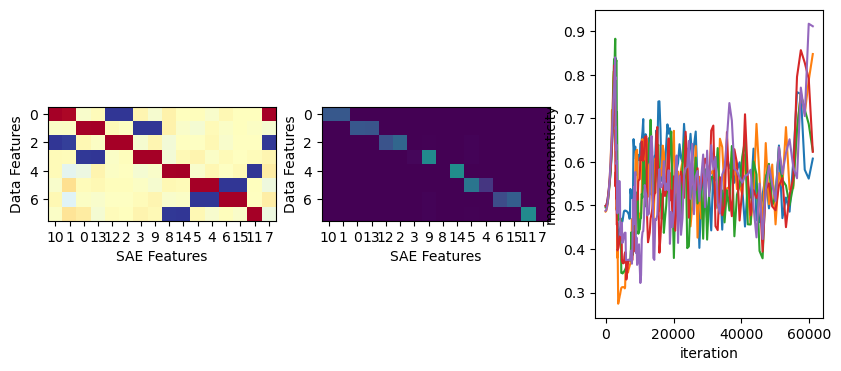

In [26]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set**2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

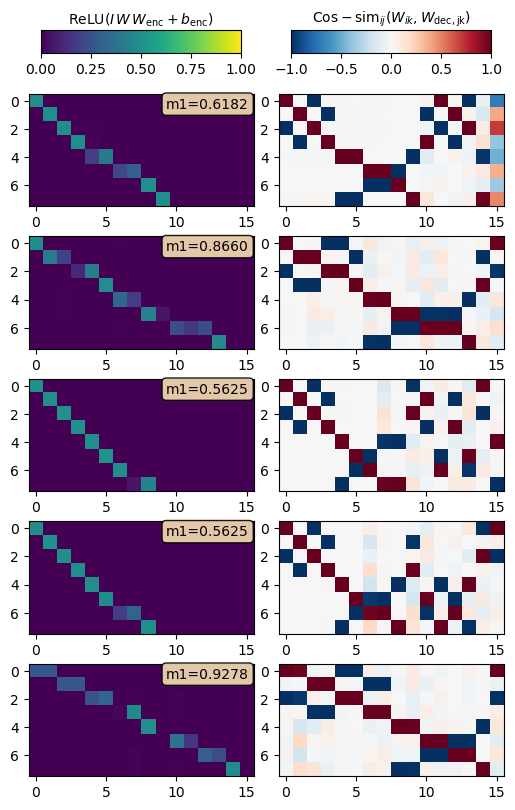

In [38]:

plot_sae_imshows(single_sae, sae_log)

### Model and simple SAEs (3 hidden dims)

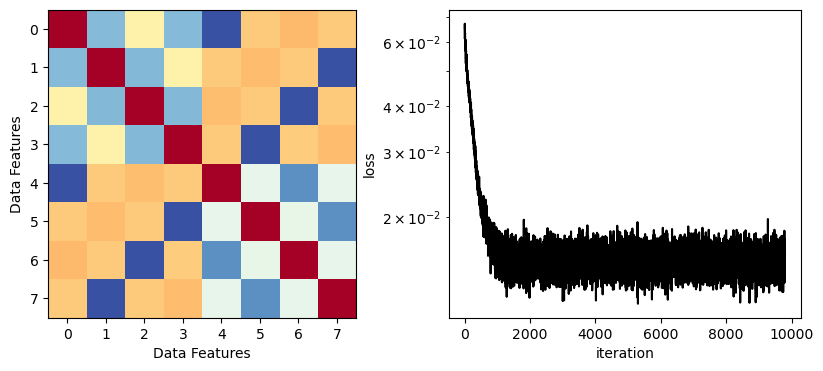

In [60]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
hidden_size = 3
feats_per_set = 4
cfg = ToyModelConfig(hidden_size=hidden_size,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

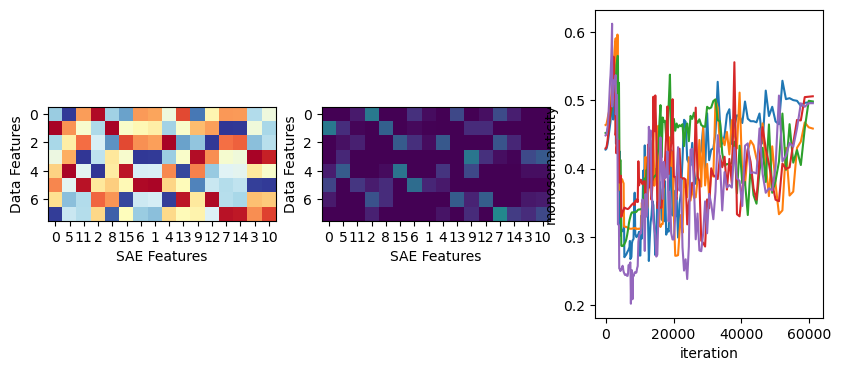

In [61]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set**2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

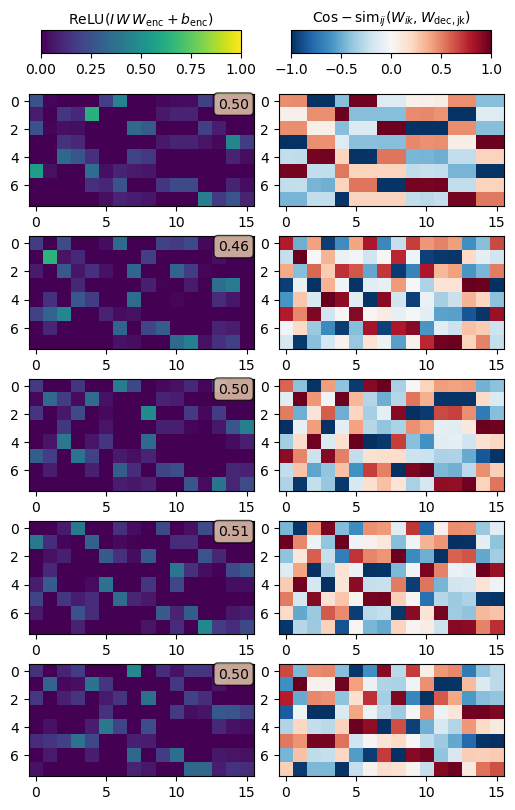

In [62]:

plot_sae_imshows(single_sae, sae_log)

# Small composed models (16 features, 2 sets)

## Uncorrelated feature amplitudes

### Model and simple SAEs

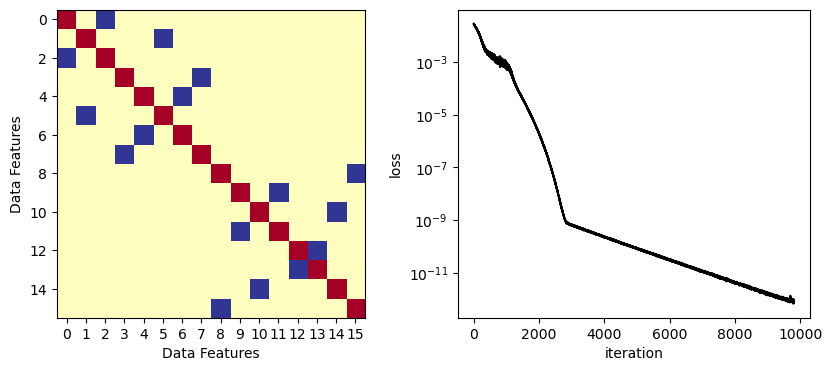

In [64]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 8
cfg = ToyModelConfig(hidden_size=feats_per_set,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

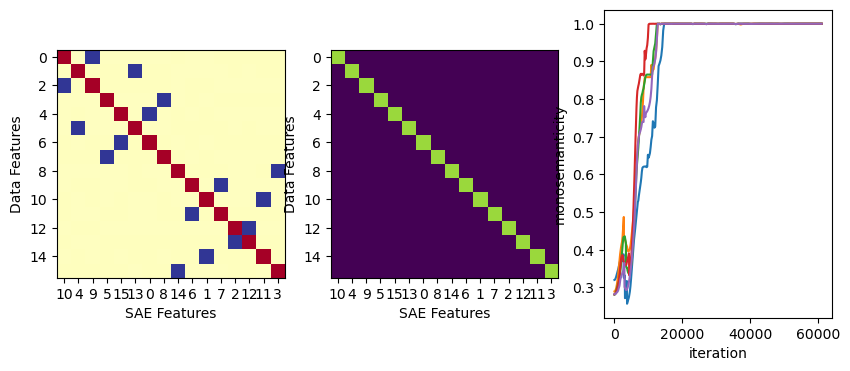

In [65]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

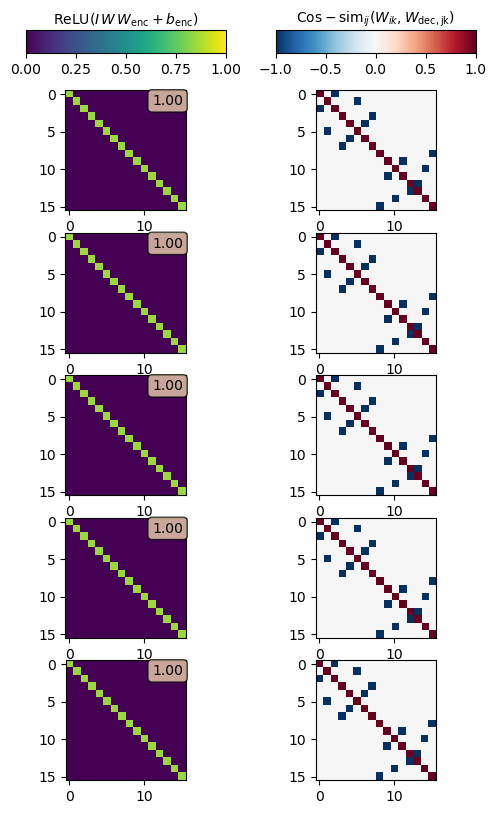

In [66]:

plot_sae_imshows(single_sae, sae_log)

### Model and simple SAEs (6 hidden dims)

Note 7 hidden dims is kinda interesting cause one block is antipodal.

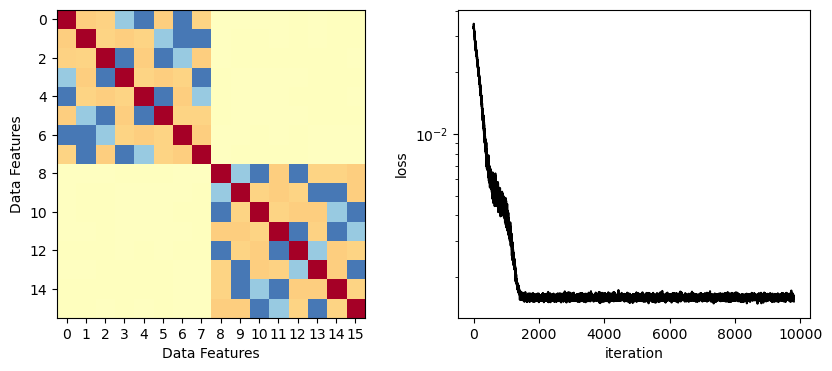

In [70]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
hidden_size = 6
feats_per_set = 8
cfg = ToyModelConfig(hidden_size=hidden_size,
                     feat_sets=(feats_per_set,feats_per_set),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

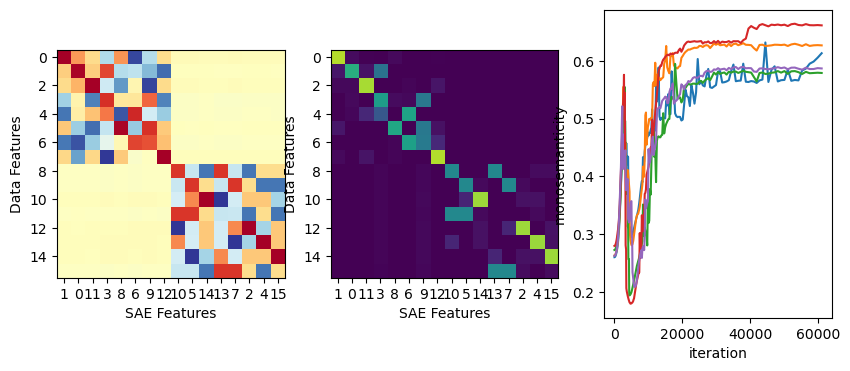

In [76]:
lr=3e-4
l1_coeff = 0.5 #0.3 does not produce sparsity OR composed pairs!
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

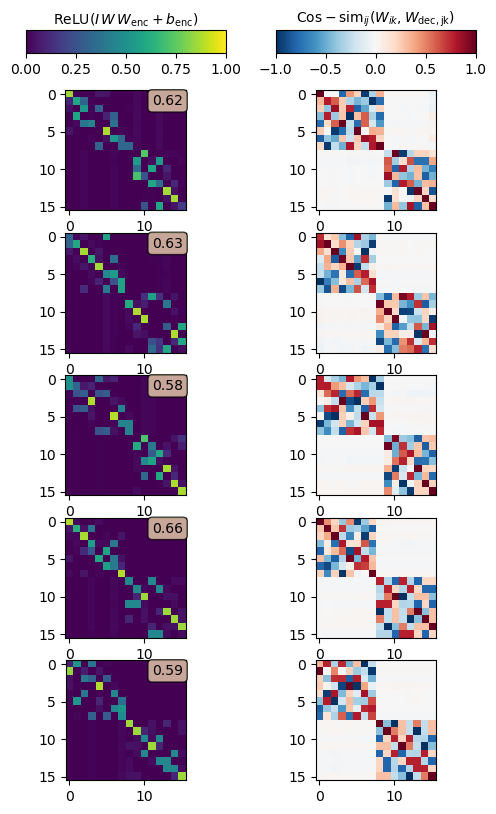

In [77]:

plot_sae_imshows(single_sae, sae_log)

### SAE grid training

running ninst5_din6_dsae16-L1-1-LR-0.0003-Seed-4140255483
trying to load...
training...
Reinitializing b_dec with geometric median of activations
Previous distances: 0.9234889149665833
New distances: 0.9237728118896484
Reinitializing b_dec with geometric median of activations
Previous distances: 0.9234889149665833
New distances: 0.9237728118896484
Reinitializing b_dec with geometric median of activations
Previous distances: 0.9234889149665833
New distances: 0.9237728118896484
Reinitializing b_dec with geometric median of activations
Previous distances: 0.9234889149665833
New distances: 0.9237728118896484
Reinitializing b_dec with geometric median of activations
Previous distances: 0.9234889149665833
New distances: 0.9237728118896484


/scratch/eanders/superposition-geometry-toys/autoencoder_fns.py:272: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = t.tensor(out, dtype=self.cfg.dtype)


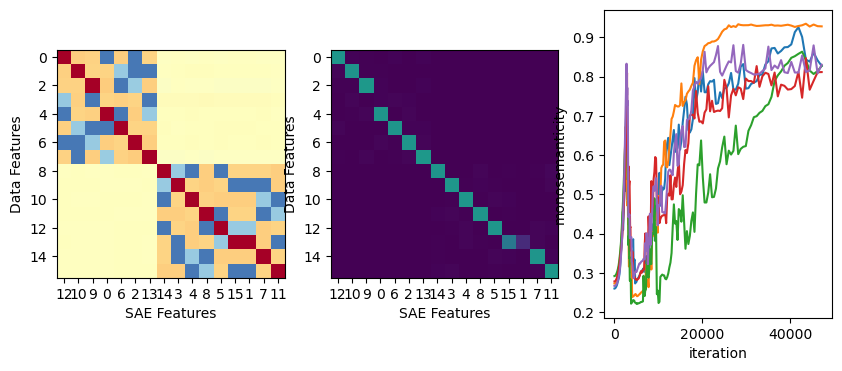

  0%|          | 0/62500 [00:00<?, ?it/s]

KeyboardInterrupt: 

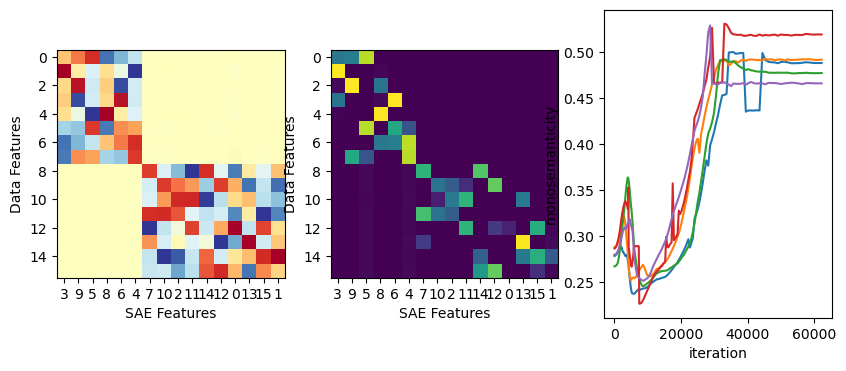

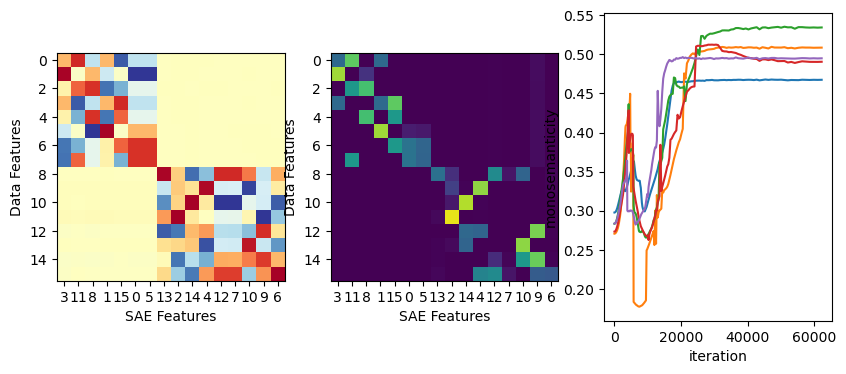

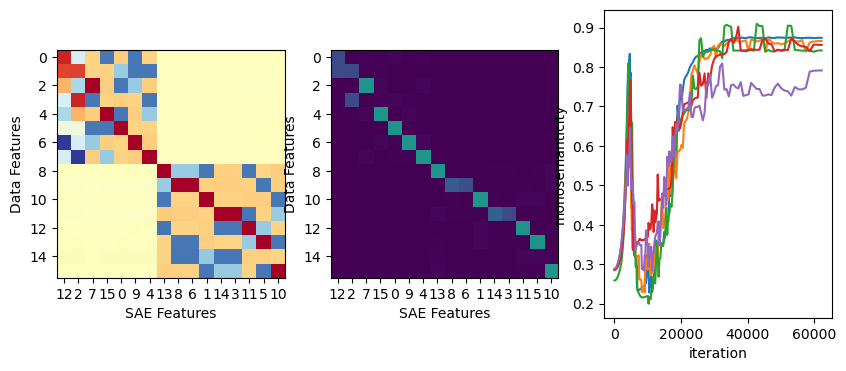

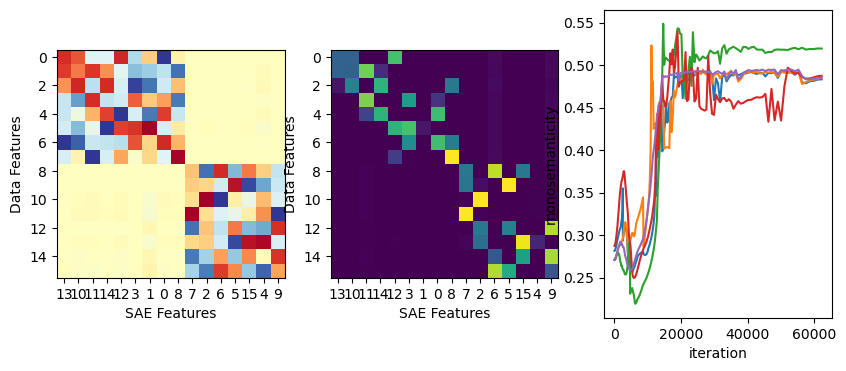

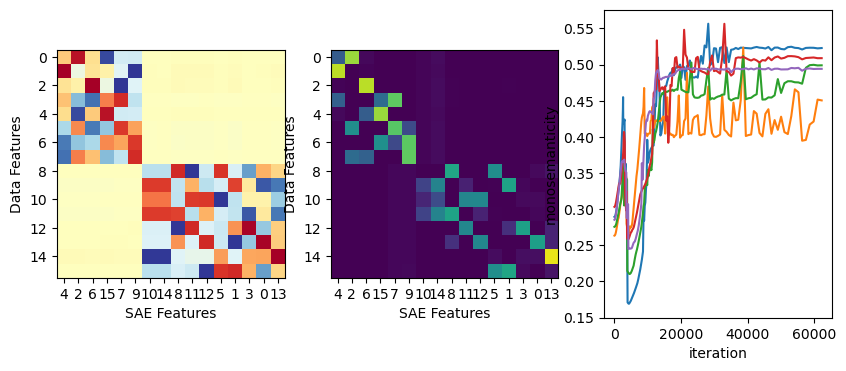

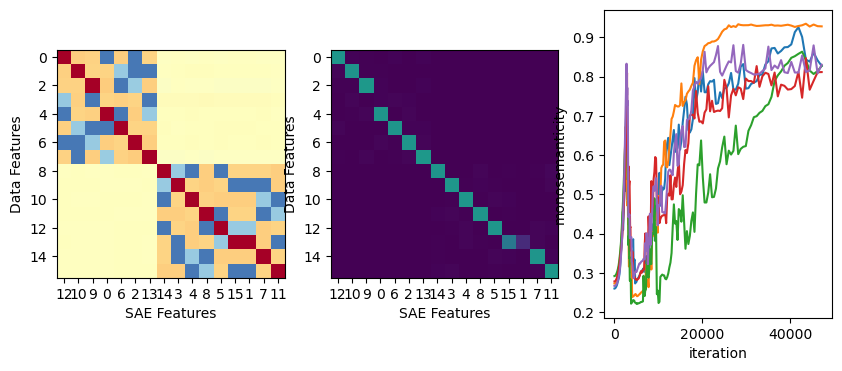

In [78]:
outdir = rootdir/'sae_uncorrelated'
outdir.mkdir(exist_ok=True)
d_sae = feats_per_set*2

saes = []
sae_logs = []
#can add a loop here and append
proj_name = f"4hiddendim-autoencoder-uncorrelated"
for lr in [1e-4, 3e-4, 1e-3]:
    for l1_coeff in [0.1, 0.3, 1]:
        en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                                n_inst=5,
                                training_samples = 64_000_000,
                                dict_mult=d_sae/cfg.hidden_size,
                                lr=lr,
                                adam_beta1=0,
                                wandb_project=proj_name,
                                l1_coeff=l1_coeff,
                                pre_encoder_bias=False,
                                log_to_wandb=False
                                )
        print('running {}'.format(en_cfg.run_name))
        encoder = AutoEncoder(en_cfg).to(device)
        try:
            print('trying to load...')
            sae_log = encoder.load(outdir, run_name=en_cfg.run_name)
        except:
            print('training...')
            sae_log = encoder.train(model,rootdir=outdir)
        saes.append((encoder, model))
        sae_logs.append(sae_log)

0.0001 0.1
0.0001 0.3
0.0001 1
0.0003 0.1
0.0003 0.3
0.0003 1


IndexError: list index out of range

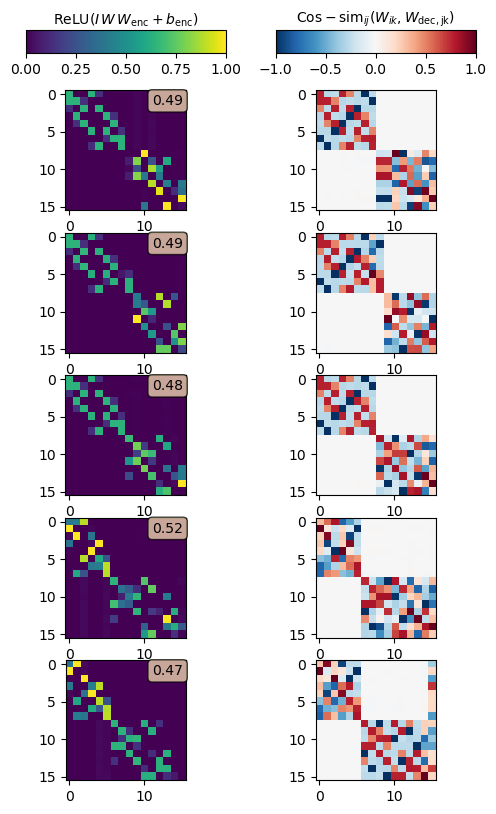

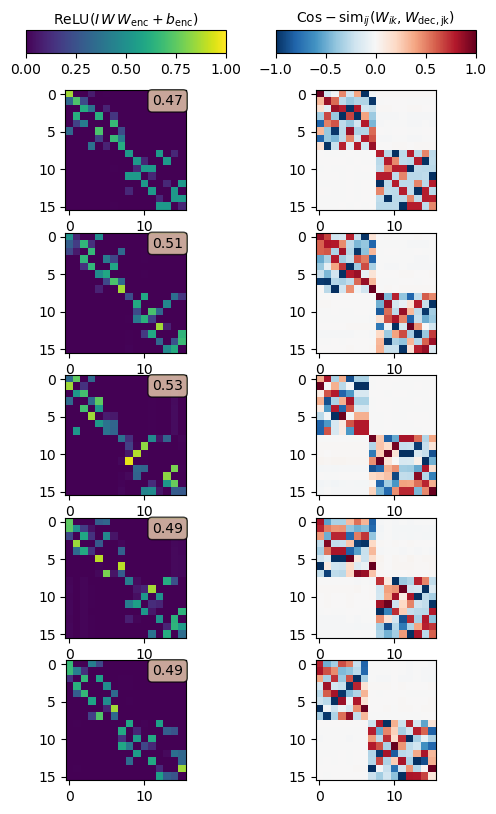

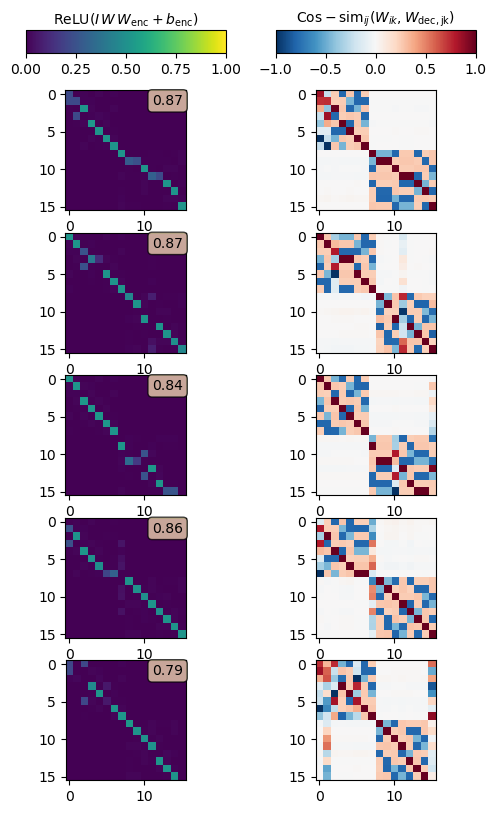

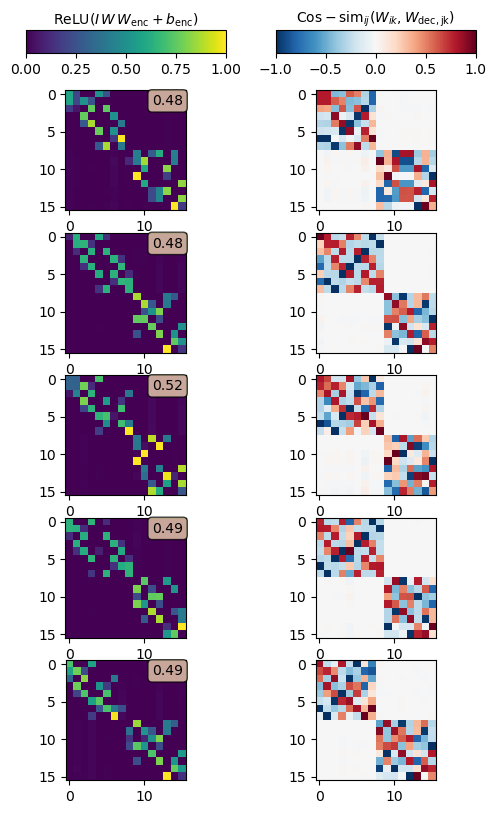

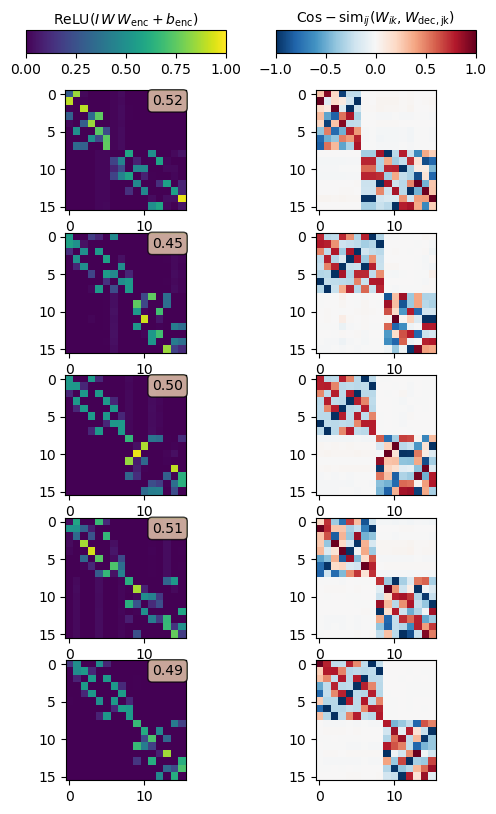

In [80]:
i = 0
for lr in [1e-4, 3e-4, 1e-3]:
    for l1_coeff in [0.1, 0.3, 1]:
        print(lr, l1_coeff)
        plot_sae_imshows(saes[i][0], sae_logs[i])
        i += 1

## One increasingly correlated feature pair; correlated magnitudes.

### Model and simple SAEs

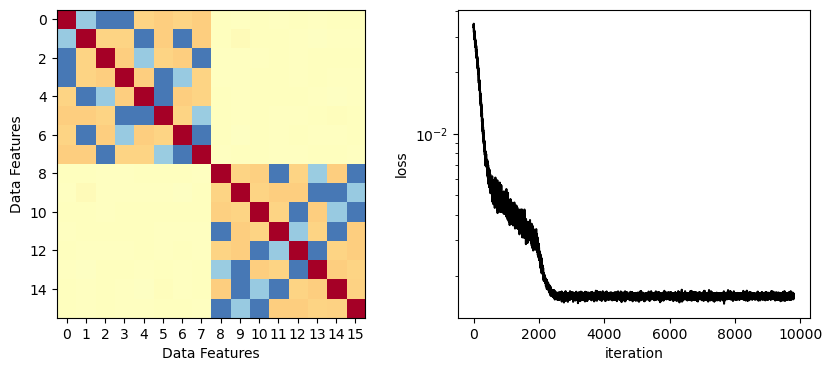

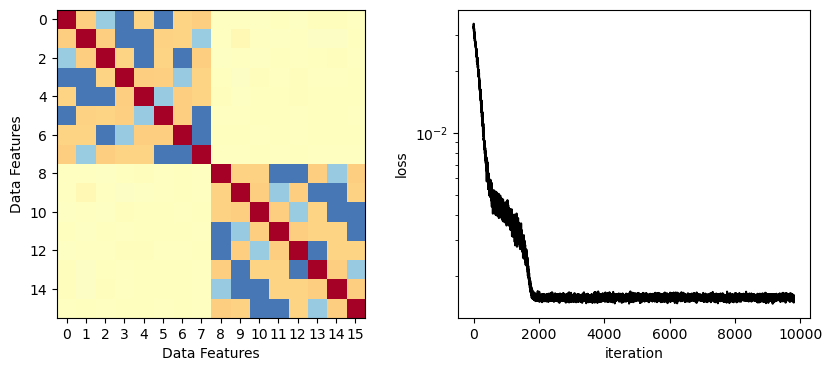

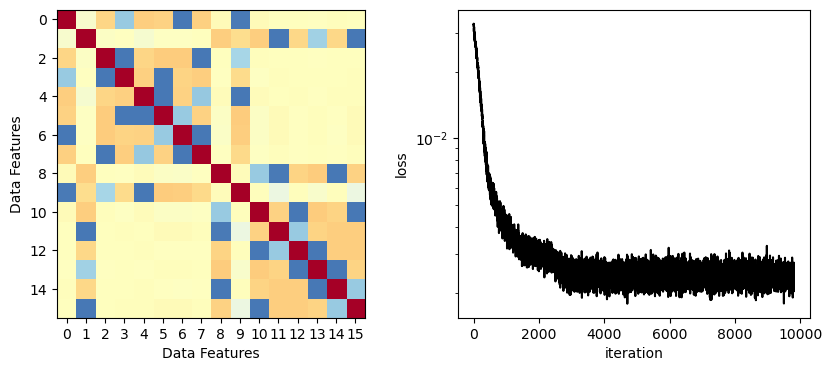

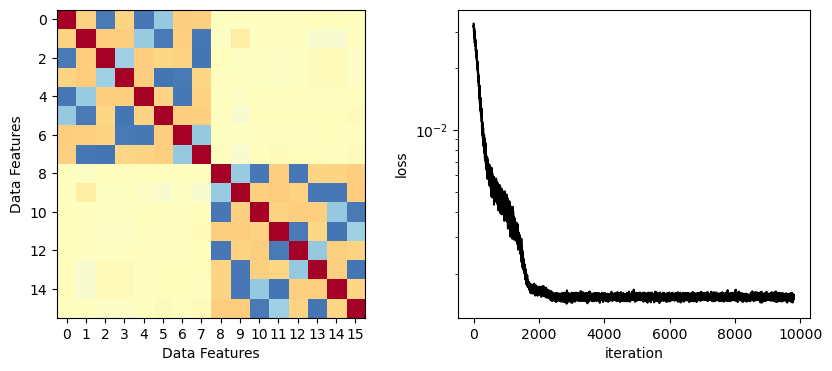

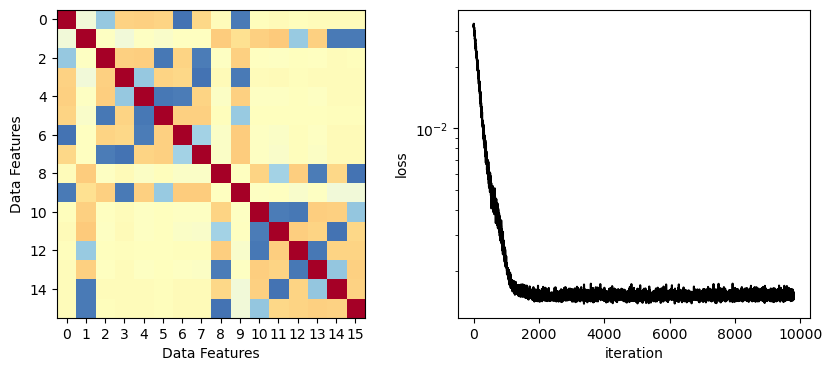

In [81]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 8
hidden_size=6
correlations = [0.2, 0.4, 0.6, 0.8, 0.99]
correlated_models = []

for corr in correlations:
    cfg = ToyModelConfig(hidden_size=hidden_size,
                         feat_sets=(feats_per_set,feats_per_set),
                         batches=10000, 
                         batch_size=1000,
                         correlated_feature_indices=(1,1),
                         correlated_feature_boost=corr,
                         set_magnitude_correlation=0,
                         active_features_per_draw=1, # seems important for getting composed pairs.
                         )
    
    model = ComposedFeatureTMS(cfg).to(device)
    try:
        print('attempting to load')
        model.load(outdir, run_name=cfg.run_name)
    except:
        print('training')
        model.train(outdir=outdir)
    correlated_models.append(model)

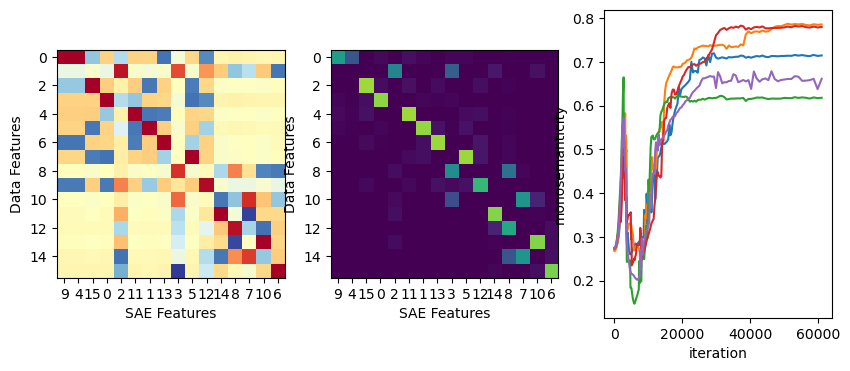

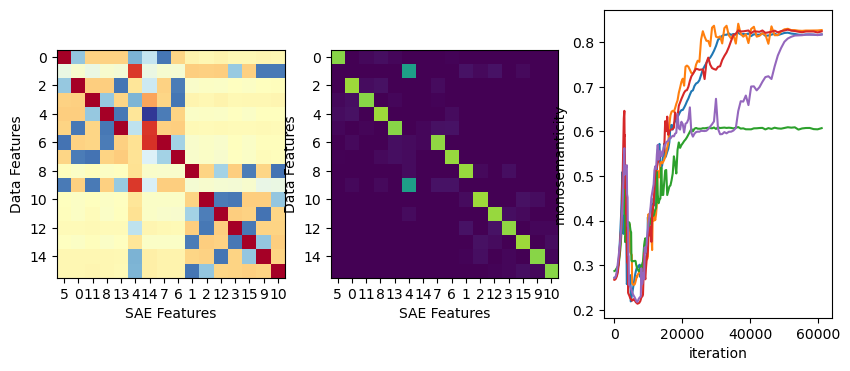

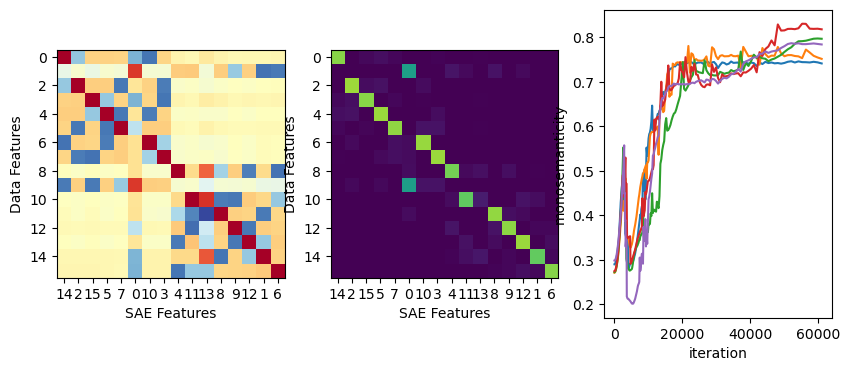

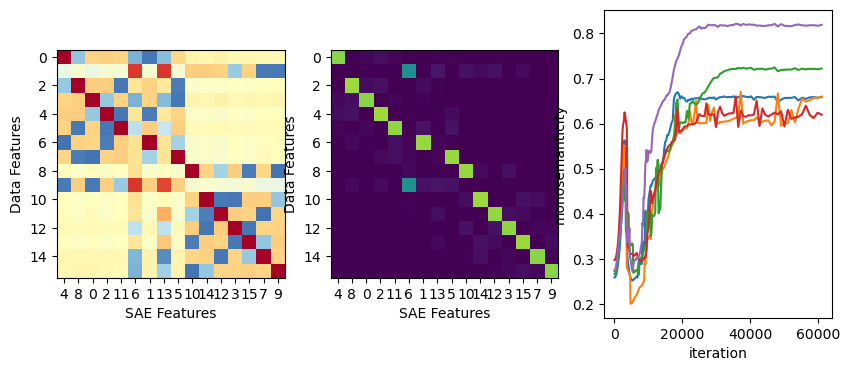

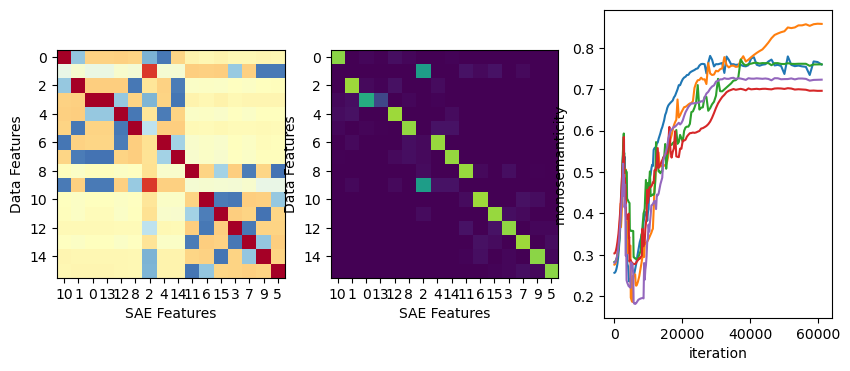

In [86]:
lr=3e-4
l1_coeff = 0.6
d_sae = feats_per_set*2

saes = []
sae_logs = []
for corr in correlations:
    #can add a loop here and append
    proj_name = f"autoencoder-uncorrelated"
    en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                            n_inst=5,
                            training_samples = 64_000_000,
                            dict_mult=d_sae/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False
                            )
    print('running {}'.format(en_cfg.run_name))
    encoder = AutoEncoder(en_cfg).to(device)
    # help(encoder.train)
    outdir = rootdir/'8_in_6_saes'
    outdir.mkdir(exist_ok=True)
    sae_log = encoder.train(model,rootdir=outdir, plot_cadence=1000)
    saes.append((encoder, model))
    sae_logs.append(sae_log)

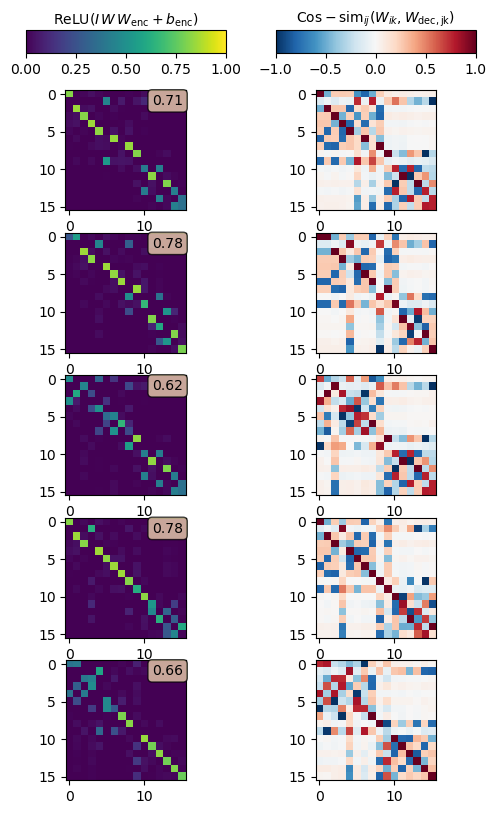

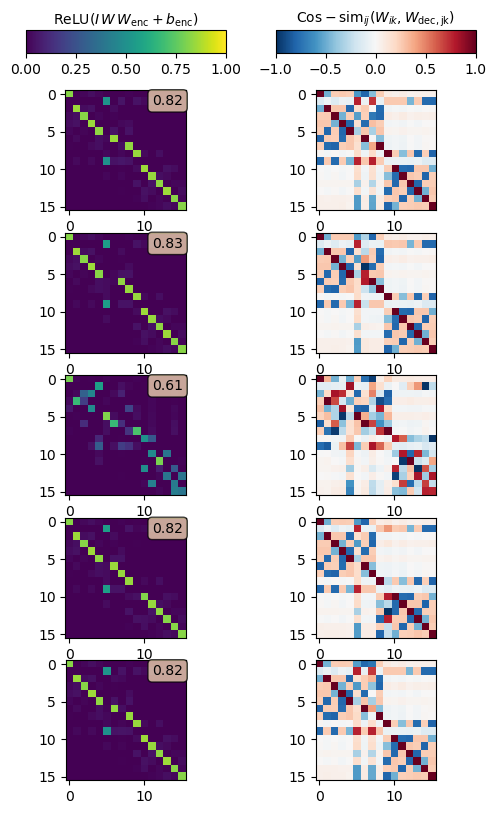

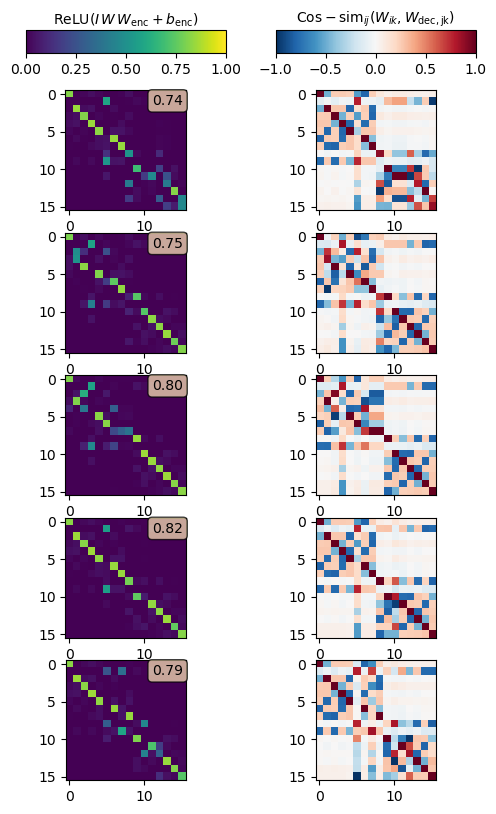

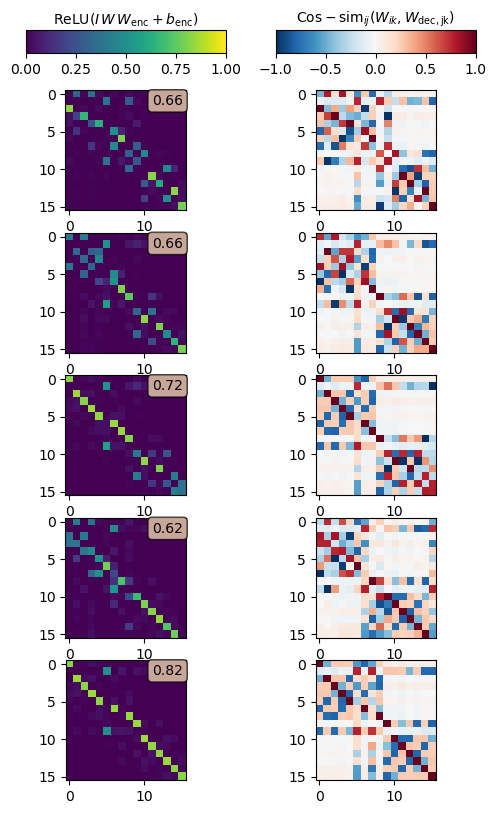

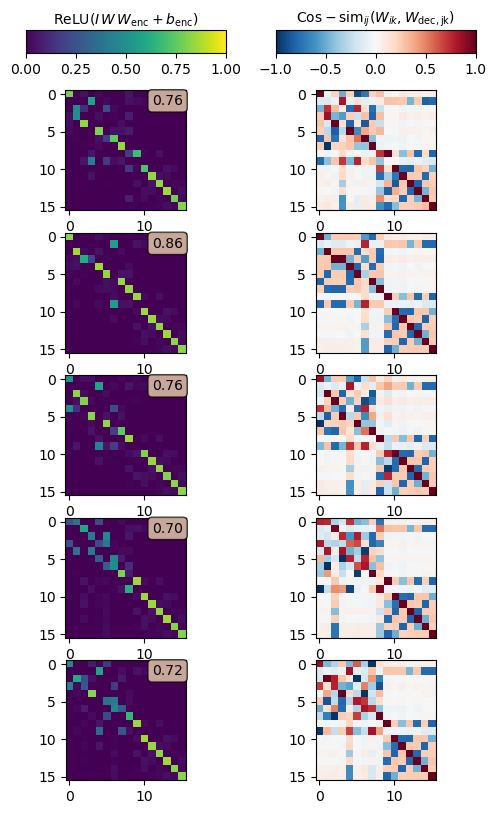

In [87]:
for i, corr in enumerate(correlations):
    plot_sae_imshows(saes[i][0], sae_logs[i])

## One increasingly correlated feature pair; correlated magnitudes.

### Model and simple SAEs

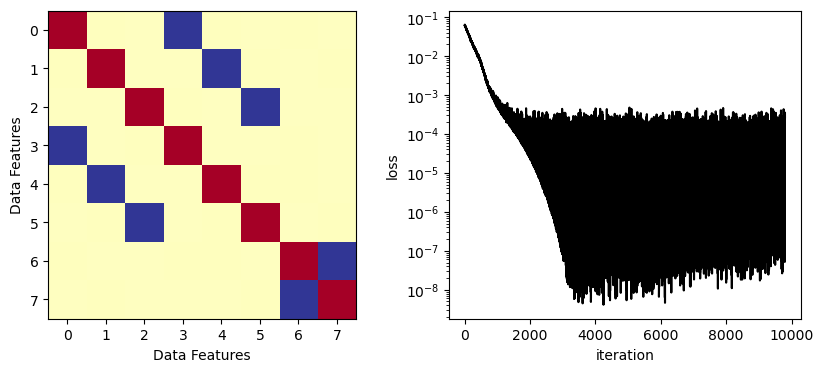

In [43]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 4
correlations = [0.2, 0.4, 0.6, 0.8, 0.99]
correlated_models = []

for corr in correlations:
    cfg = ToyModelConfig(hidden_size=feats_per_set,
                         feat_sets=(feats_per_set,feats_per_set),
                         batches=10000, 
                         batch_size=1000,
                         correlated_feature_indices=(1,1),
                         correlated_feature_boost=corr,
                         set_magnitude_correlation=0,
                         active_features_per_draw=1, # seems important for getting composed pairs.
                         )
    
    model = ComposedFeatureTMS(cfg).to(device)
    try:
        print('attempting to load')
        model.load(outdir, run_name=cfg.run_name)
    except:
        print('training')
        model.train(outdir=outdir)
    correlated_models.append(model)

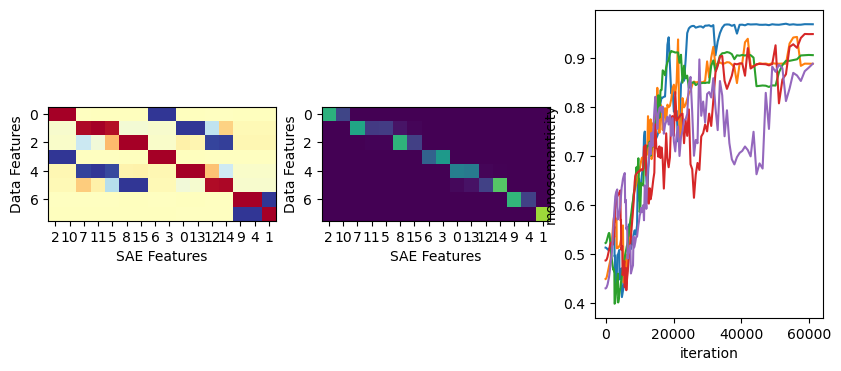

In [44]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set**2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

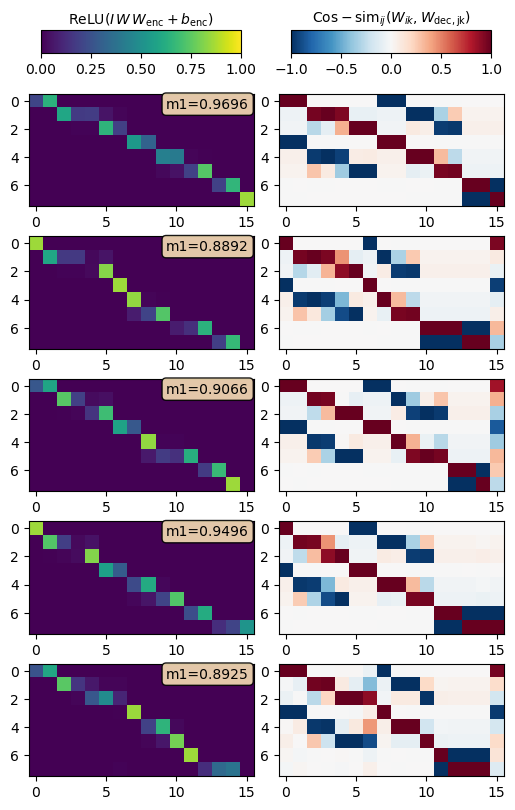

In [45]:
plot_sae_imshows(single_sae, sae_log)

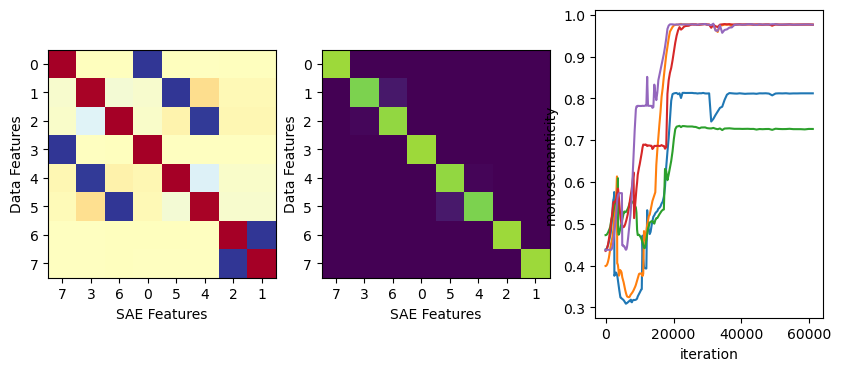

In [46]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

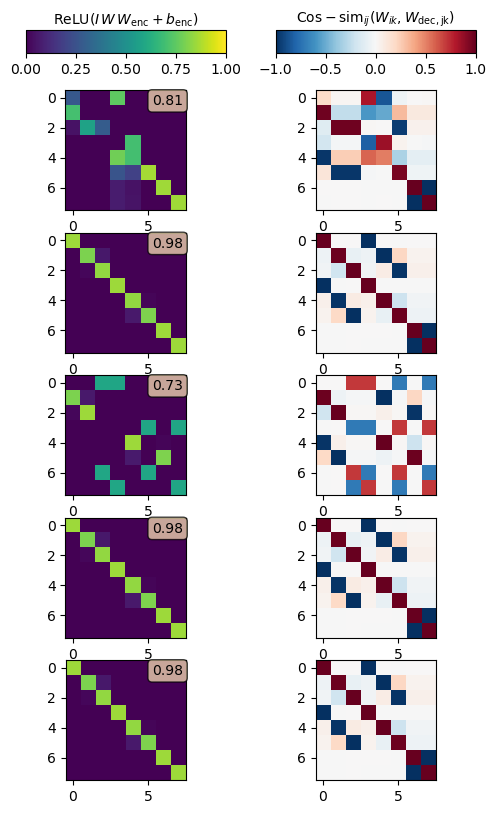

In [49]:
plot_sae_imshows(single_sae, sae_log)

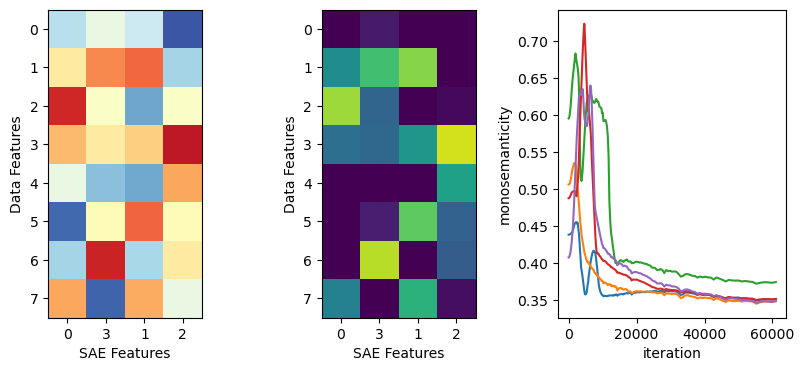

In [50]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

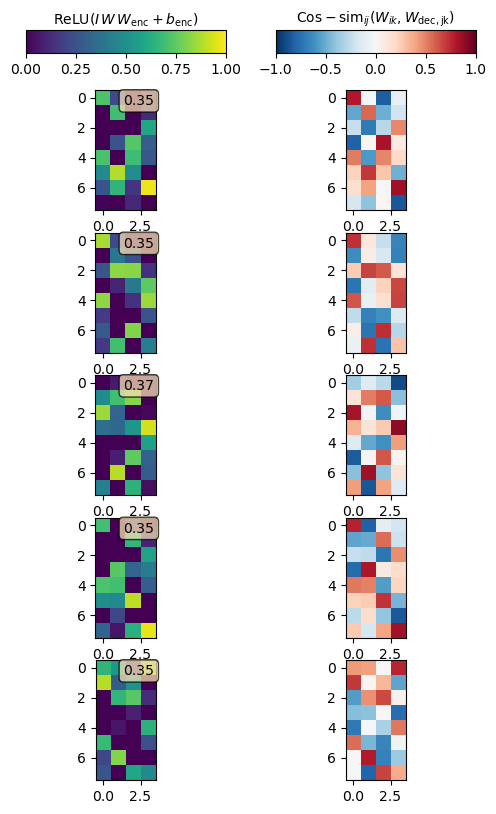

In [51]:
plot_sae_imshows(single_sae, sae_log)

### SAE grid training

In [ ]:
for corr, model in zip(correlations, correlated_models):
    outdir = rootdir/f'sae_one_correlated_corr{corr:.2f}'
    outdir.mkdir(exist_ok=True)
    d_sae = feats_per_set**2
    
    saes = []
    sae_logs = []
    #can add a loop here and append
    proj_name = f"4hiddendim-autoencoder-corr{corr:.2f}"
    for lr in [3e-5, 1e-4,3e-4, 1e-3, 3e-3]:
        for l1_coeff in [1e-2, 3e-2, 1e-1, 3e-1, 1e0]:
            en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                                    n_inst=5,
                                    training_samples = 128_000_000,
                                    dict_mult=d_sae/cfg.hidden_size,
                                    lr=lr,
                                    adam_beta1=0,
                                    wandb_project=proj_name,
                                    l1_coeff=l1_coeff,
                                    pre_encoder_bias=False,
                                    log_to_wandb=False
                                    )
            print('running {}'.format(en_cfg.run_name))
            encoder = AutoEncoder(en_cfg).to(device)
            try:
                sae_log = encoder.load(outdir, run_name=en_cfg.run_name)
            except:
                sae_log = encoder.train(model,rootdir=outdir)
            saes.append((encoder, model))
            sae_logs.append(sae_log)

## Model and simple SAEs with more superposition

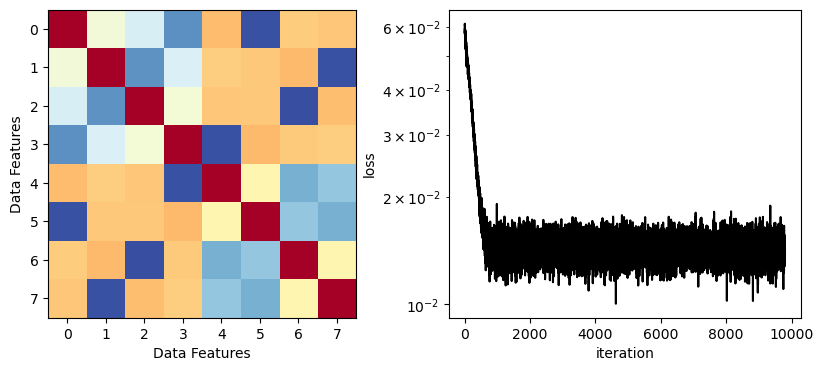

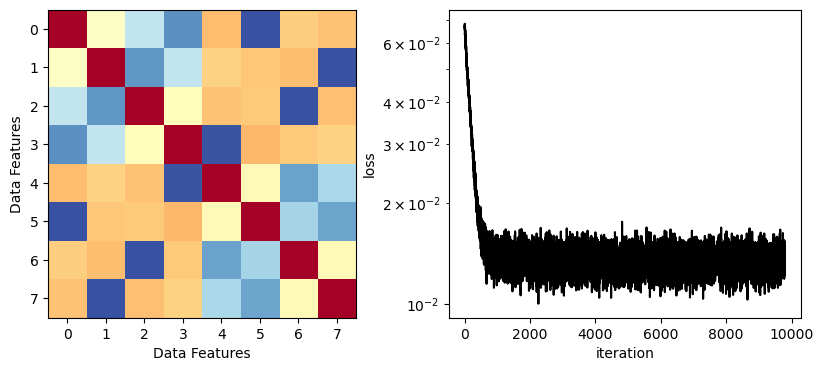

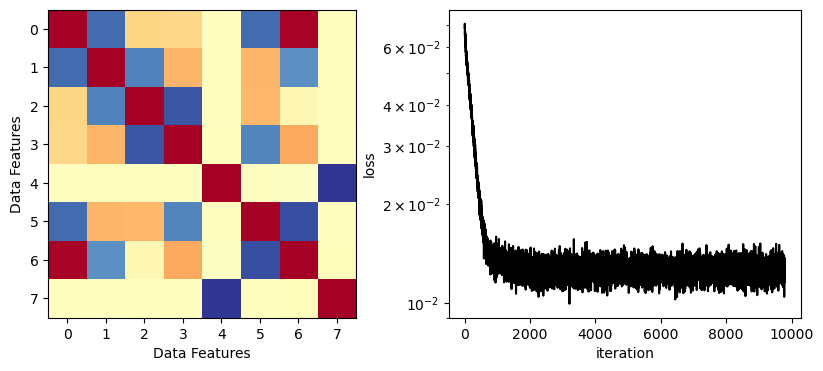

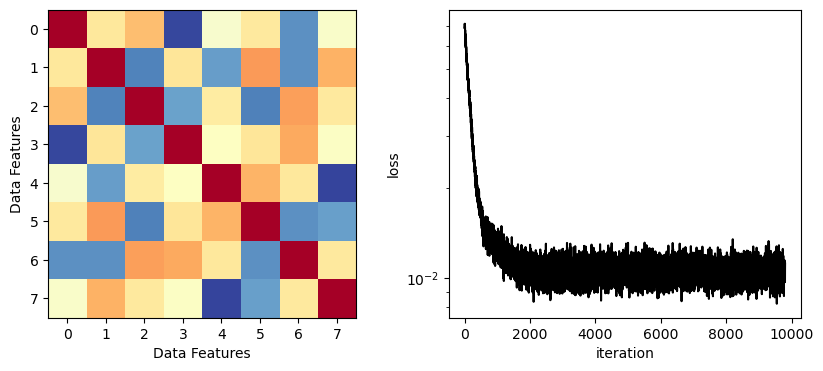

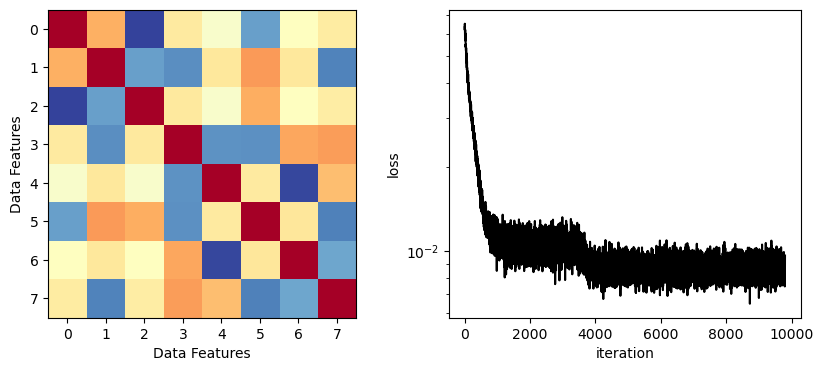

In [53]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
feats_per_set = 4
hidden_size = 3
correlations = [0.2, 0.4, 0.6, 0.8, 0.99]
correlated_models = []

for corr in correlations:
    cfg = ToyModelConfig(hidden_size=hidden_size,
                         feat_sets=(feats_per_set,feats_per_set),
                         batches=10000, 
                         batch_size=1000,
                         correlated_feature_indices=(1,1),
                         correlated_feature_boost=corr,
                         set_magnitude_correlation=0,
                         active_features_per_draw=1, # seems important for getting composed pairs.
                         )
    
    model = ComposedFeatureTMS(cfg).to(device)
    try:
        print('attempting to load')
        model.load(outdir, run_name=cfg.run_name)
    except:
        print('training')
        model.train(outdir=outdir)
    correlated_models.append(model)

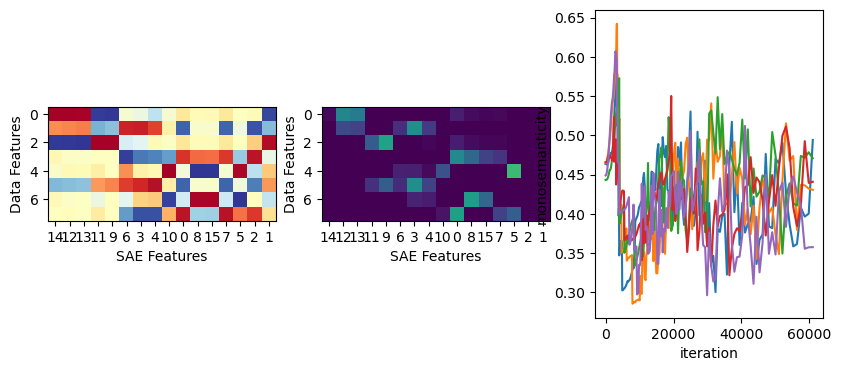

In [54]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set**2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

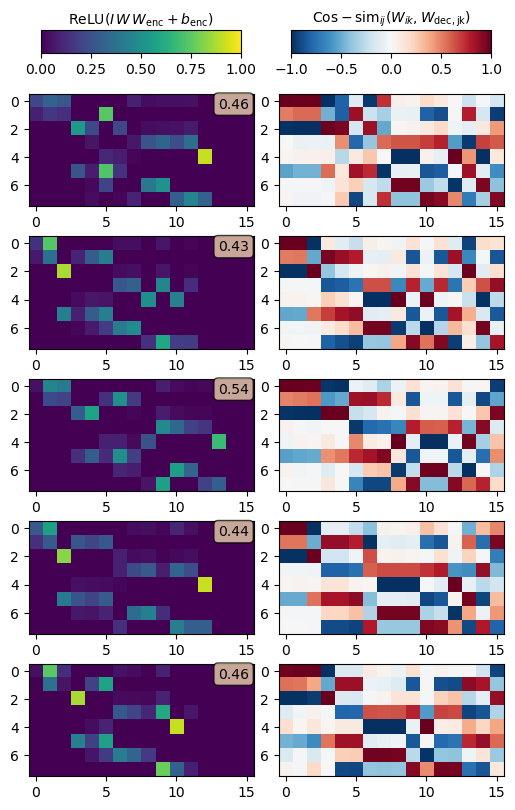

In [55]:
plot_sae_imshows(single_sae, sae_log)

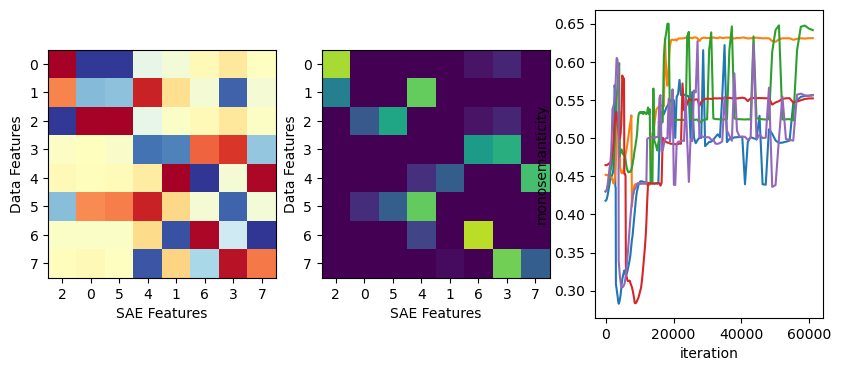

In [56]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set*2

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

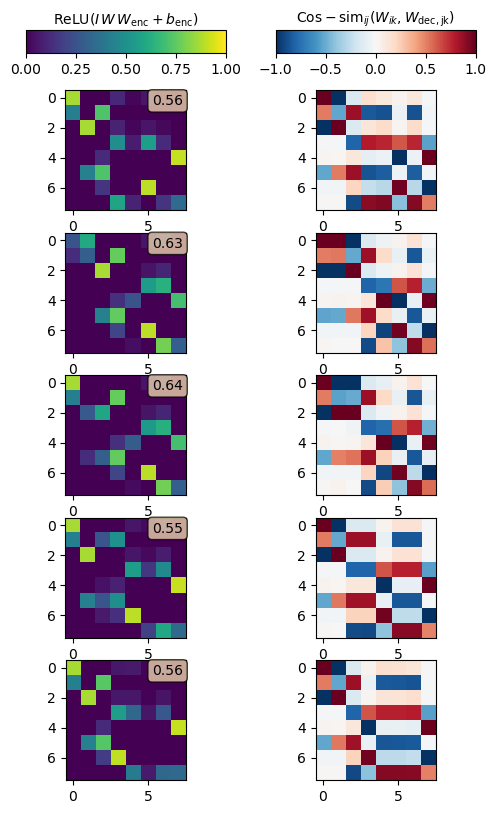

In [57]:
plot_sae_imshows(single_sae, sae_log)

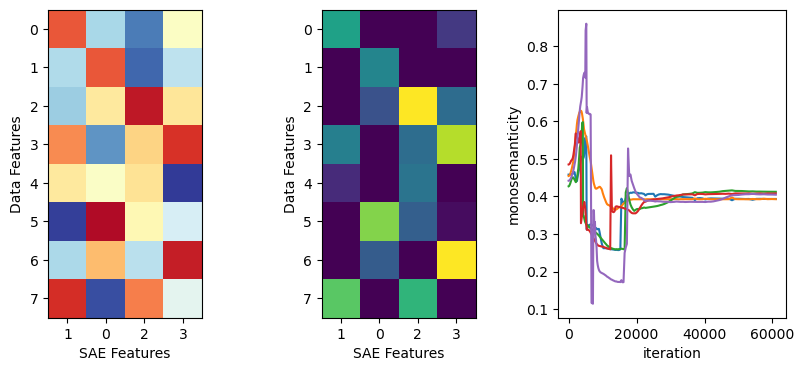

In [58]:
lr=3e-4
l1_coeff = 0.3
d_sae = feats_per_set

#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 64_000_000,
                        dict_mult=d_sae/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
# help(encoder.train)
sae_log = encoder.train(model,rootdir=rootdir, plot_cadence=1000)
saes.append((encoder, model))
single_sae = encoder

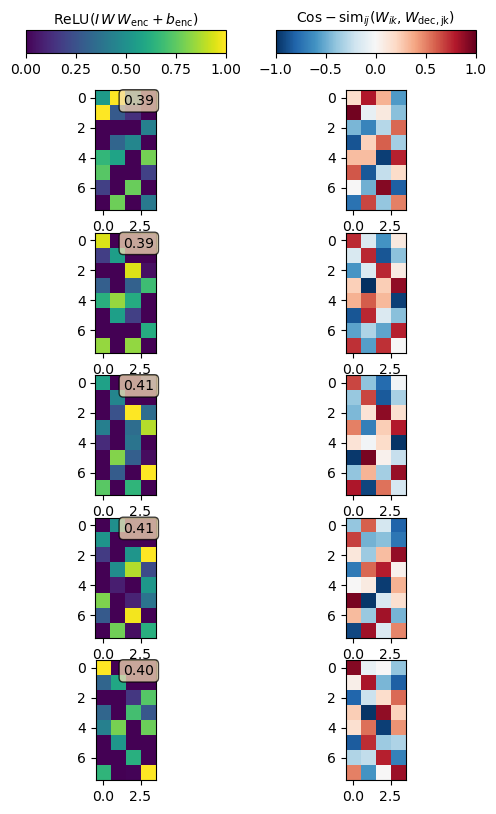

In [59]:
plot_sae_imshows(single_sae, sae_log)

### SAE grid training

In [ ]:
for corr, model in zip(correlations, correlated_models):
    outdir = rootdir/f'sae_one_correlated_corr{corr:.2f}'
    outdir.mkdir(exist_ok=True)
    d_sae = feats_per_set**2
    
    saes = []
    sae_logs = []
    #can add a loop here and append
    proj_name = f"4hiddendim-autoencoder-corr{corr:.2f}"
    for lr in [3e-5, 1e-4,3e-4, 1e-3, 3e-3]:
        for l1_coeff in [1e-2, 3e-2, 1e-1, 3e-1, 1e0]:
            en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                                    n_inst=5,
                                    training_samples = 128_000_000,
                                    dict_mult=d_sae/cfg.hidden_size,
                                    lr=lr,
                                    adam_beta1=0,
                                    wandb_project=proj_name,
                                    l1_coeff=l1_coeff,
                                    pre_encoder_bias=False,
                                    log_to_wandb=False
                                    )
            print('running {}'.format(en_cfg.run_name))
            encoder = AutoEncoder(en_cfg).to(device)
            try:
                sae_log = encoder.load(outdir, run_name=en_cfg.run_name)
            except:
                sae_log = encoder.train(model,rootdir=outdir)
            saes.append((encoder, model))
            sae_logs.append(sae_log)

# Uncorrelated with one-hot probability at 50%

### Model and first SAE

In [33]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
cfg = ToyModelConfig(hidden_size=2,
                     feat_sets=(2,2),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, 
                     onehot_probability=0.5,
                     )

model = ComposedFeatureTMS(cfg).to(device)
print(model.cfg.run_name)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)


probability table: 
tensor([[0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.1250],
        [0.1250, 0.1250, 0.0000]])
tms_nin4nhid2_numfeatsdraw1_magnitude_corr0_correlated_feature_boost0_onehot0.50
attempting to load


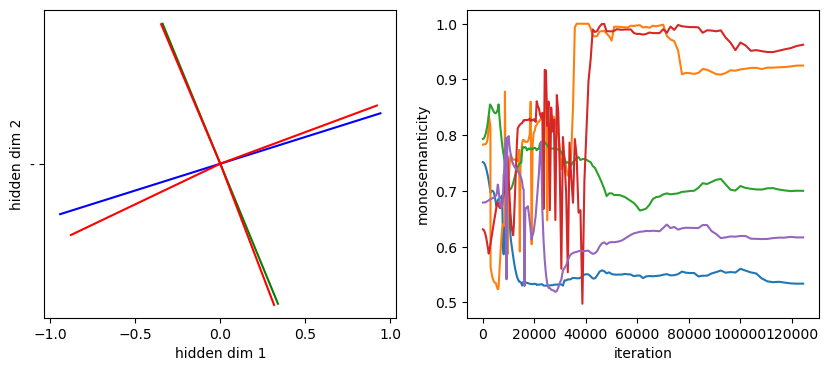

In [29]:
lr=3e-4
l1_coeff = 0.3


#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=cfg.input_size/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
sae_log = encoder.train(model,rootdir=rootdir)
saes.append((encoder, model))
single_sae = encoder

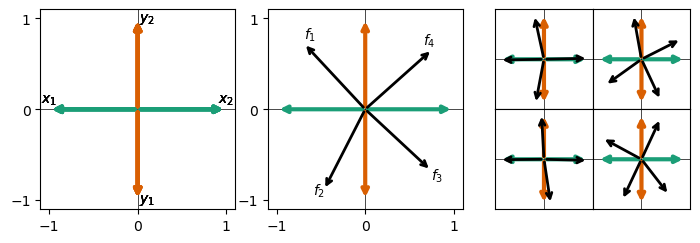

In [30]:
plot_schematic(model, single_sae, savename='2d_toy_model_schematic_oneHot50.png')

### SAE grid training

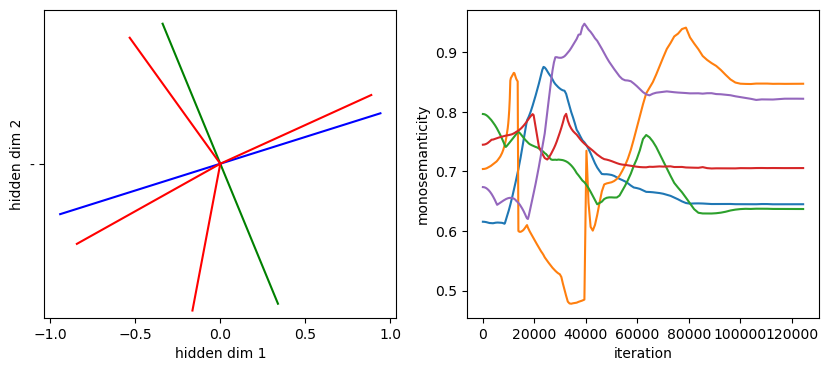

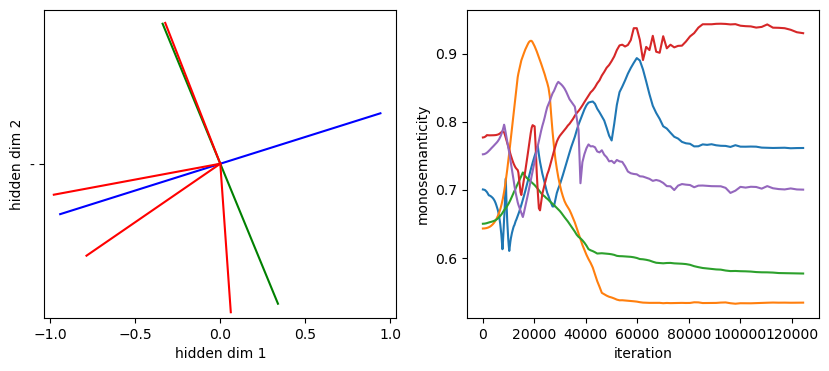

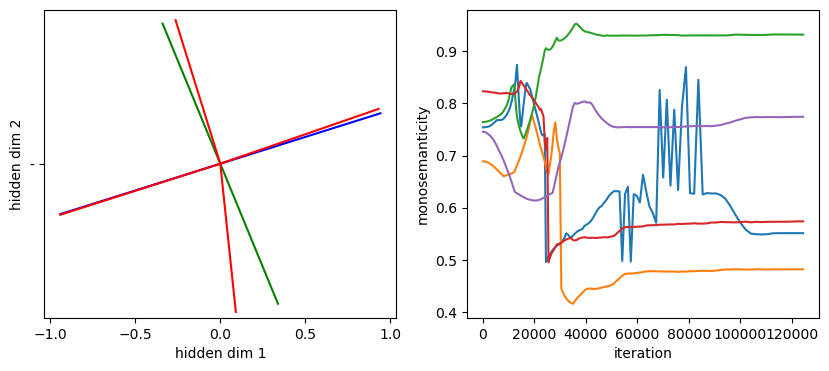

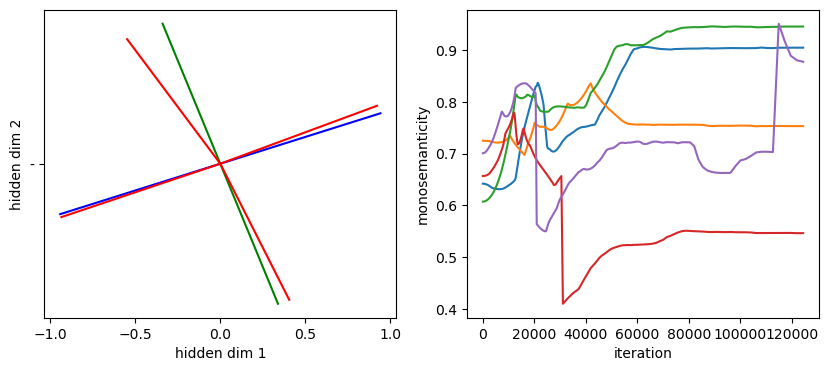

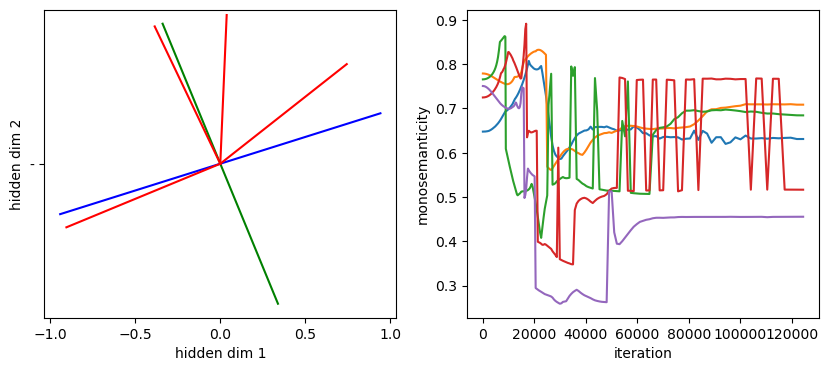

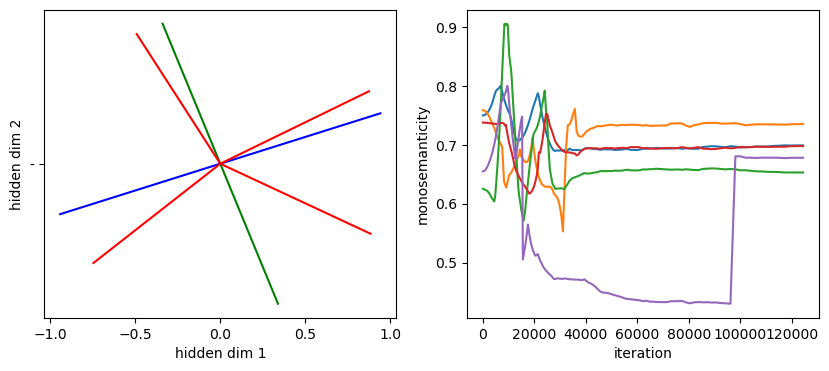

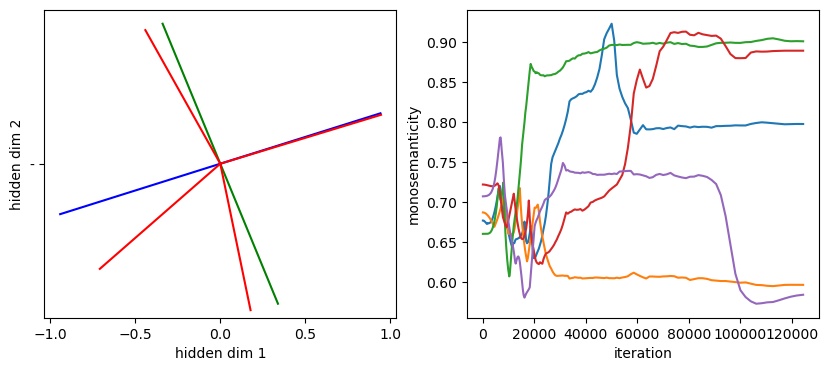

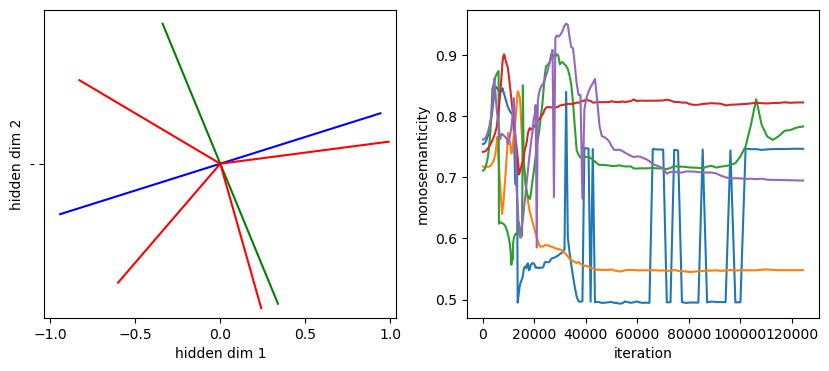

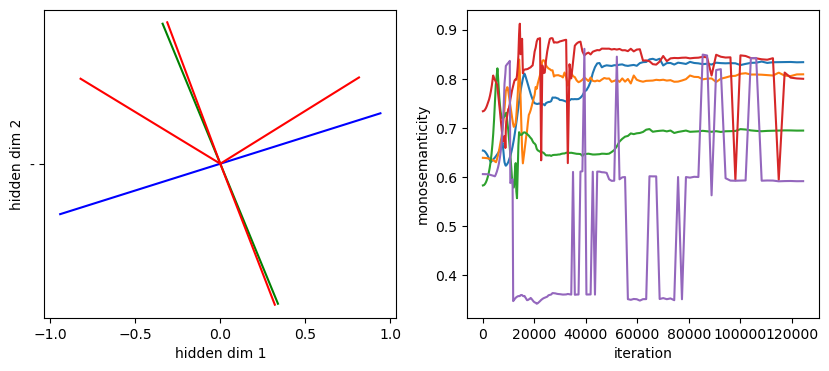

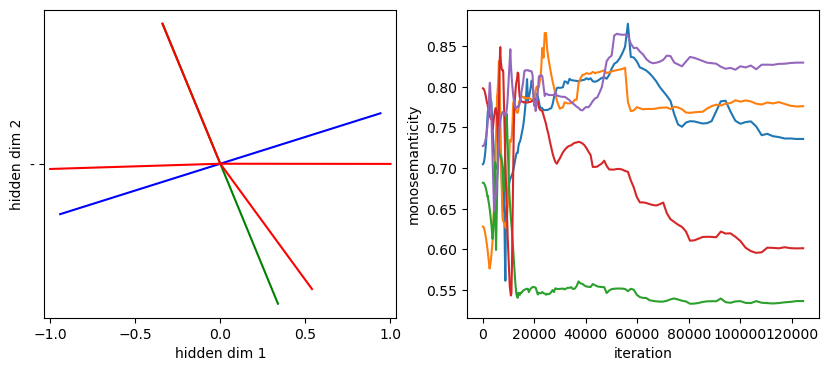

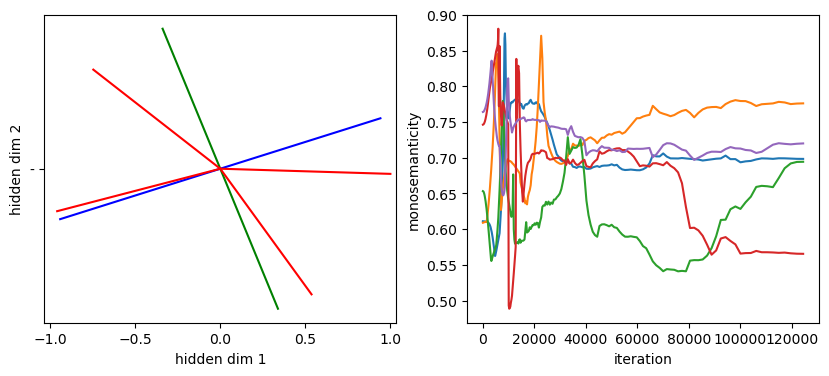

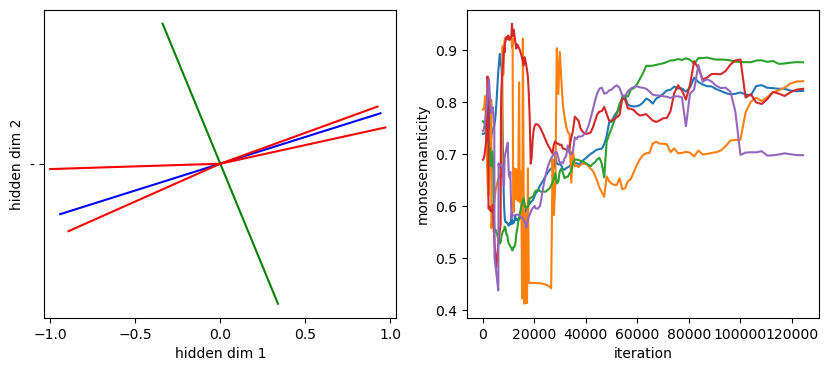

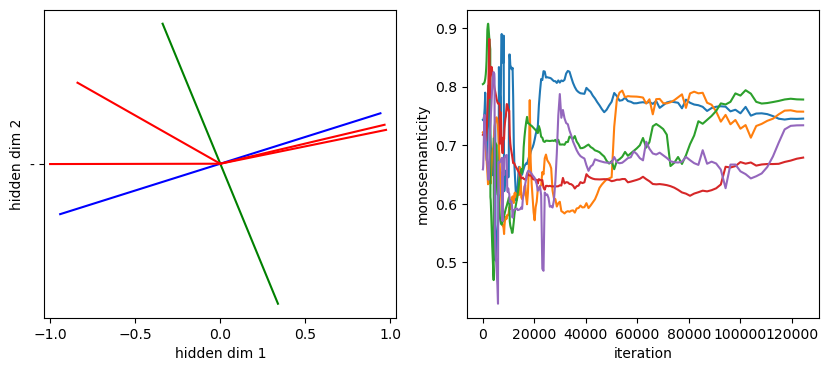

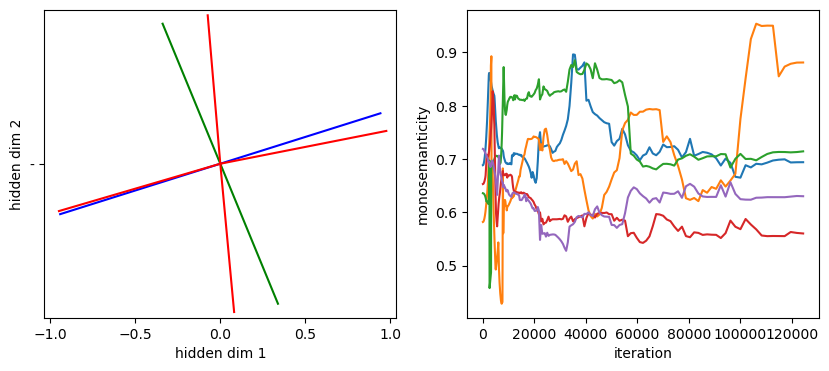

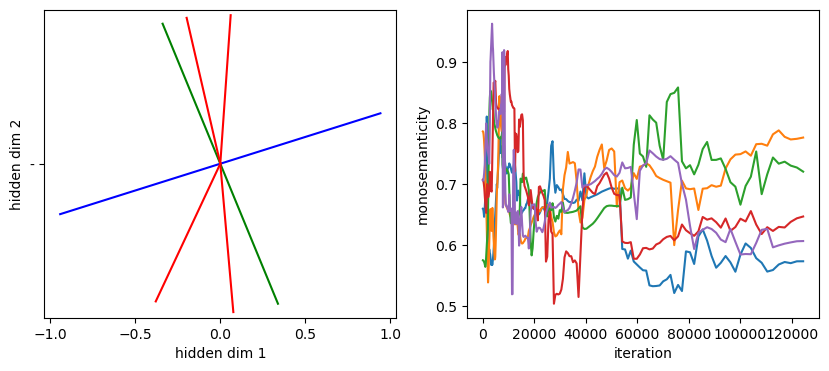

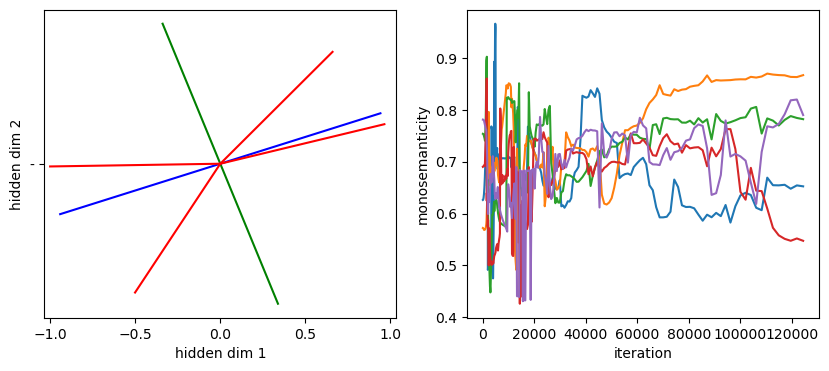

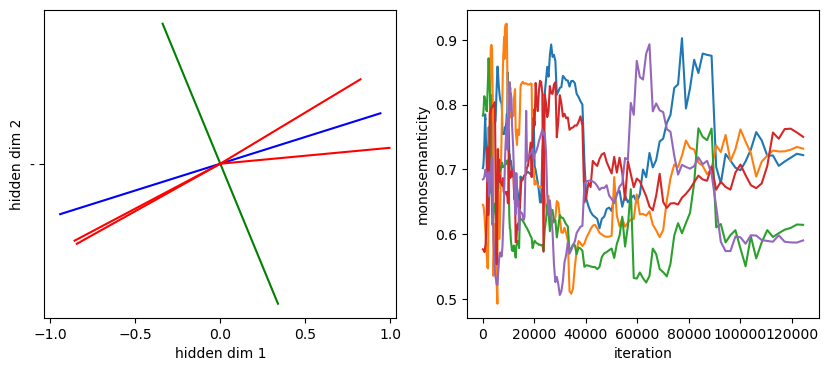

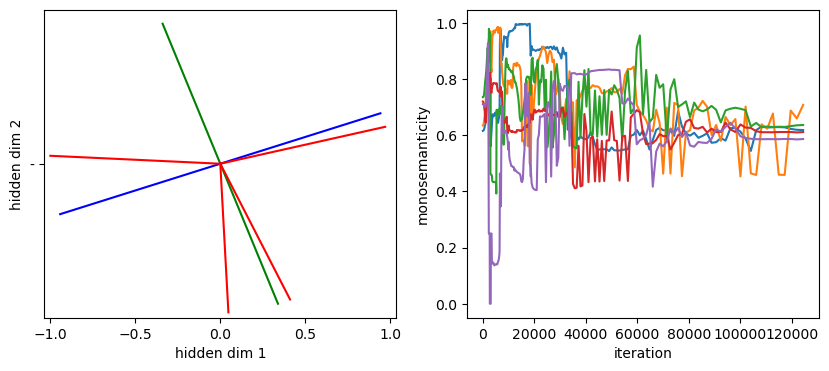

In [34]:
outdir = rootdir/'sae_OneHot50_uncorrelated'
outdir.mkdir(exist_ok=True)
d_sae = 4

saes = []
sae_logs = []
#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
for lr in [3e-5, 1e-4,3e-4, 1e-3, 3e-3]:
    for l1_coeff in [1e-2, 3e-2, 1e-1, 3e-1, 1e0]:
        en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                                n_inst=5,
                                training_samples = 128_000_000,
                                dict_mult=d_sae/cfg.hidden_size,
                                lr=lr,
                                adam_beta1=0,
                                wandb_project=proj_name,
                                l1_coeff=l1_coeff,
                                pre_encoder_bias=False
                                )
        print('running {}'.format(en_cfg.run_name))
        encoder = AutoEncoder(en_cfg).to(device)
        try:
            sae_log = encoder.load(outdir, run_name=en_cfg.run_name)
        except:
            sae_log = encoder.train(model,rootdir=outdir)
        saes.append((encoder, model))
        sae_logs.append(sae_log)
clear_output()

### SAE grid analysis

In [35]:
plot_grid(model, saes, filename='OneHot50_2d_grid.png')

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_22890/3109989520.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6.5,2))


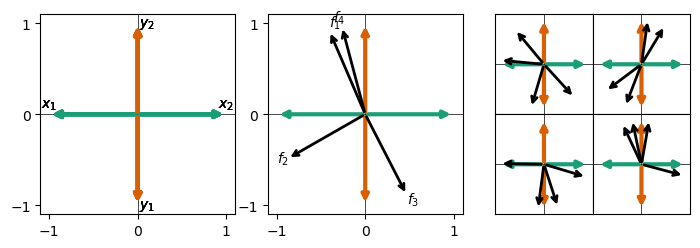

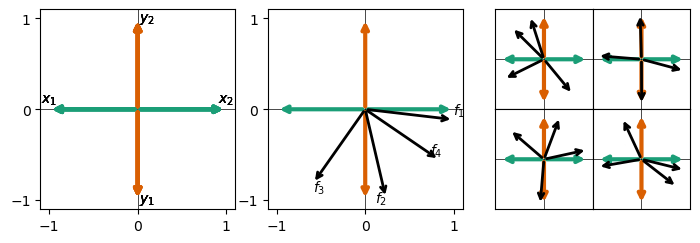

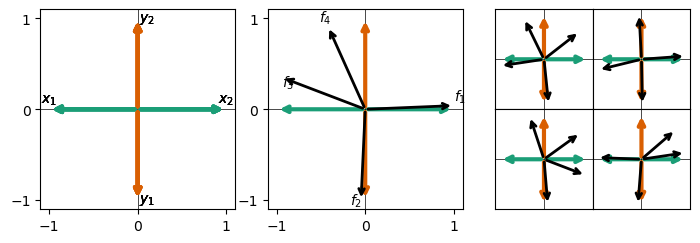

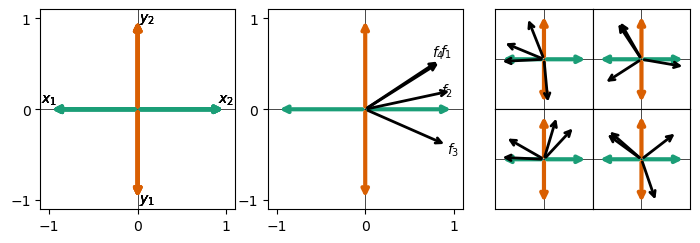

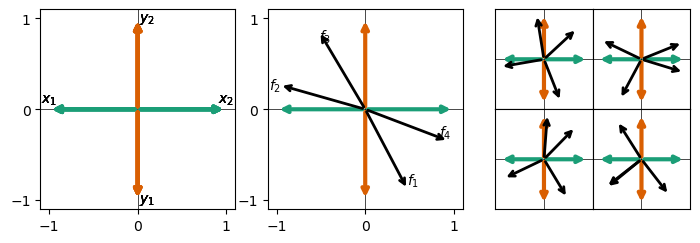

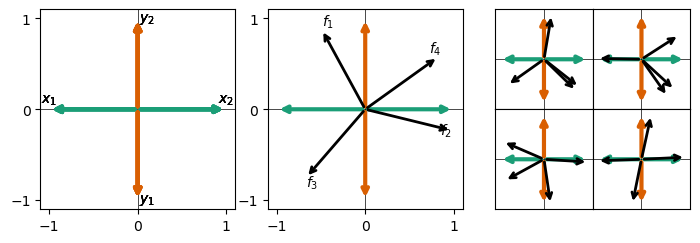

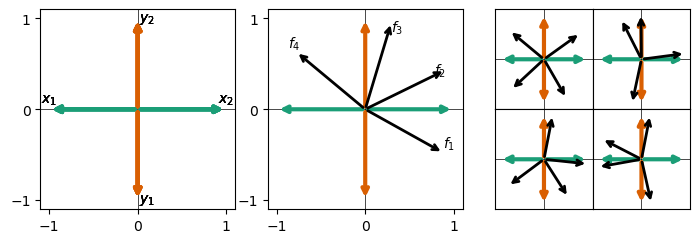

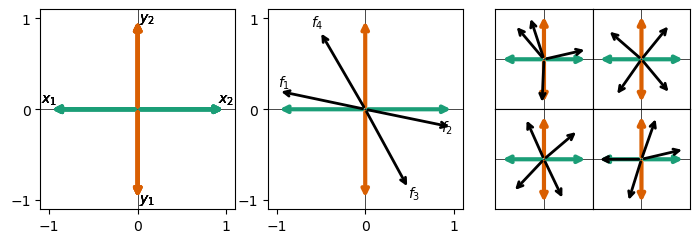

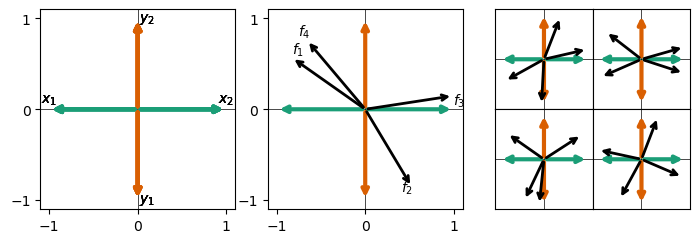

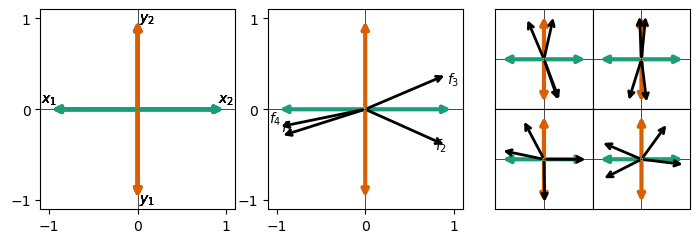

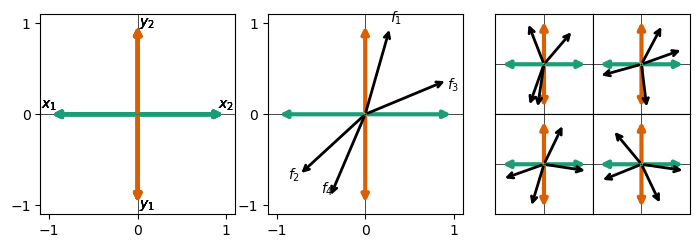

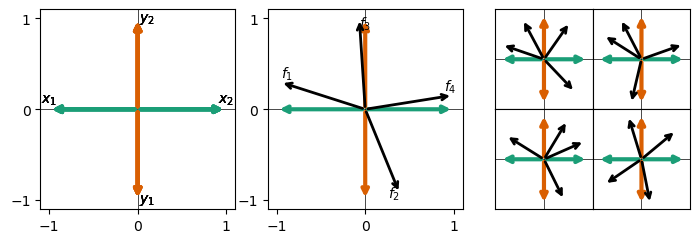

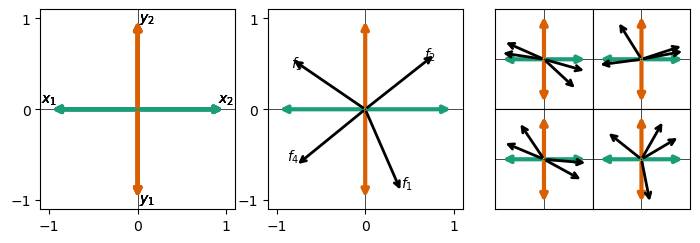

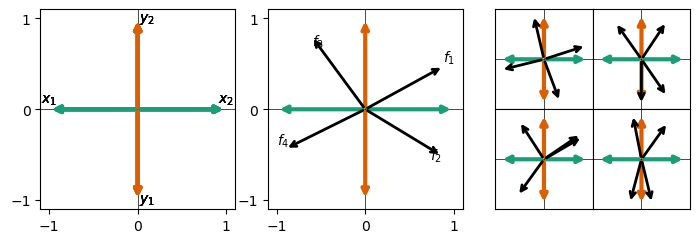

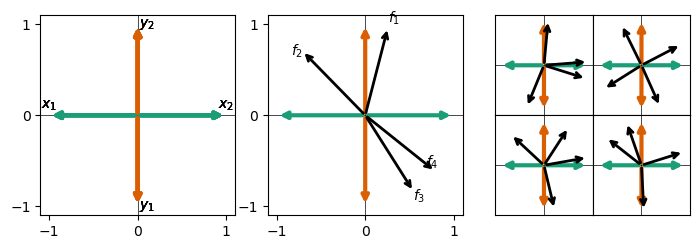

In [36]:
for i in range(len(saes)):
    plot_schematic(model, saes[i][0])

## Uncorrelated with one-hot probability at 75%

### Model and first SAE

In [32]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
cfg = ToyModelConfig(hidden_size=2,
                     feat_sets=(2,2),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, 
                     onehot_probability=0.75,
                     )

model = ComposedFeatureTMS(cfg).to(device)
print(model.cfg.run_name)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)


probability table: 
tensor([[0.0625, 0.0625, 0.1875],
        [0.0625, 0.0625, 0.1875],
        [0.1875, 0.1875, 0.0000]])
tms_nin4nhid2_numfeatsdraw1_magnitude_corr0_correlated_feature_boost0_onehot0.75
attempting to load


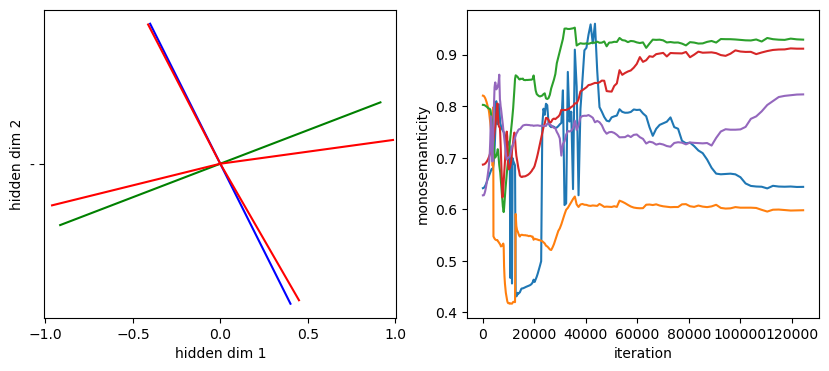

In [21]:
lr=3e-4
l1_coeff = 0.3


#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=cfg.input_size/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
sae_log = encoder.train(model,rootdir=rootdir)
saes.append((encoder, model))
single_sae = encoder

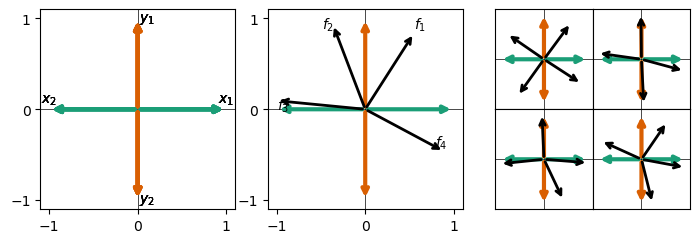

In [22]:
plot_schematic(model, single_sae, savename='2d_toy_model_schematic_oneHot75.png')

### SAE grid training

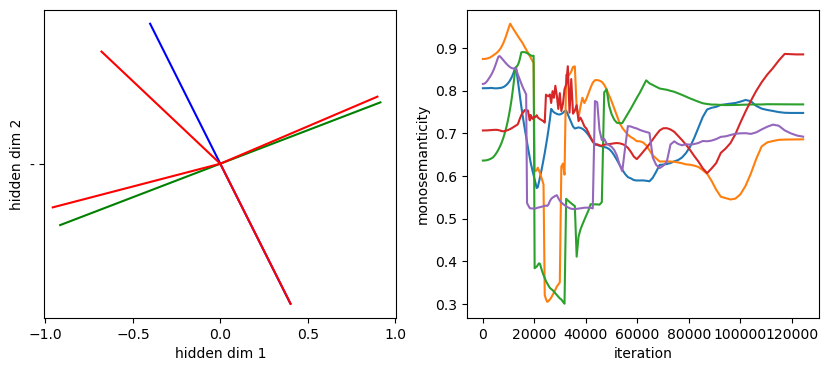

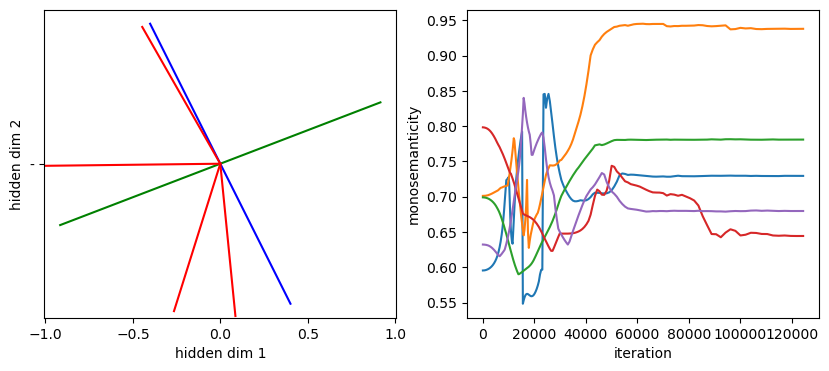

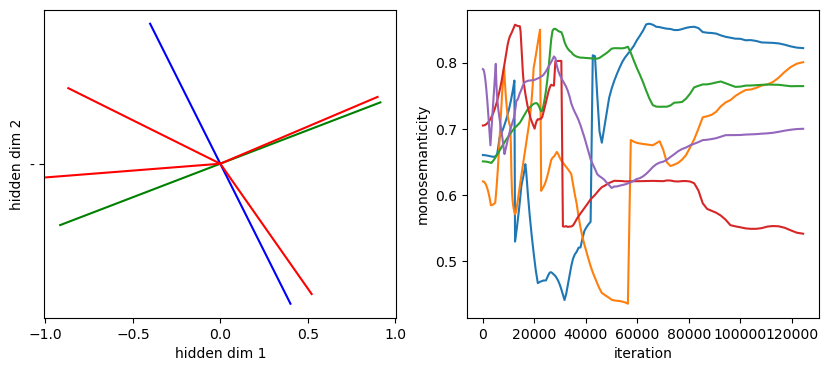

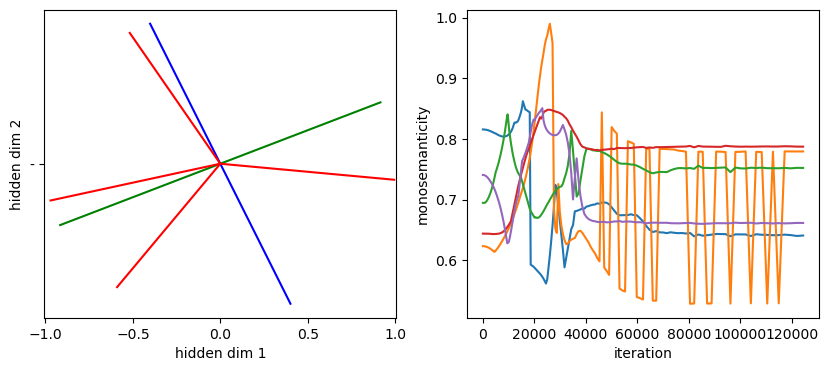

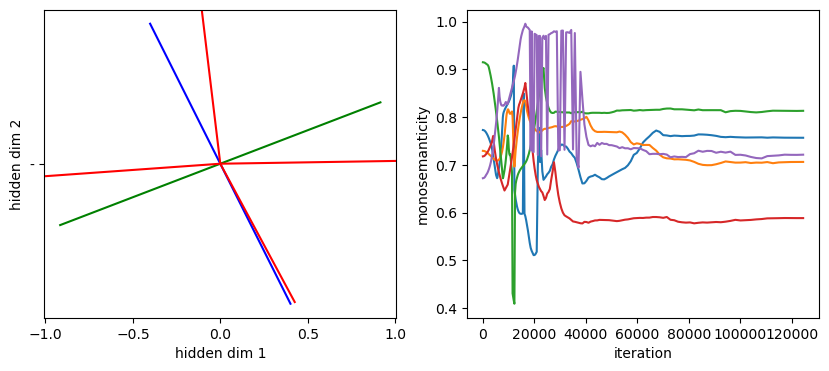

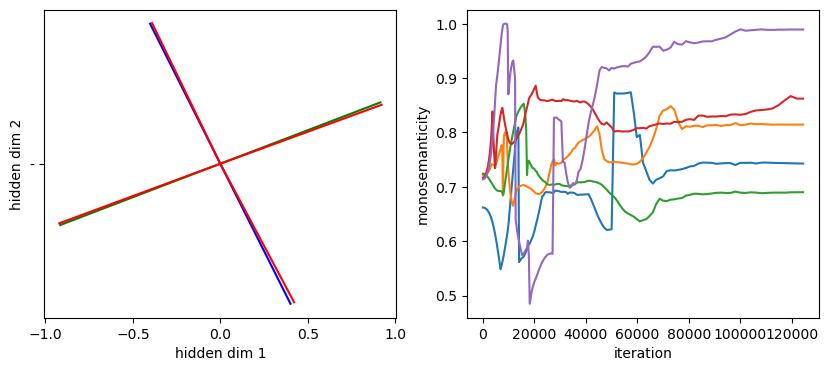

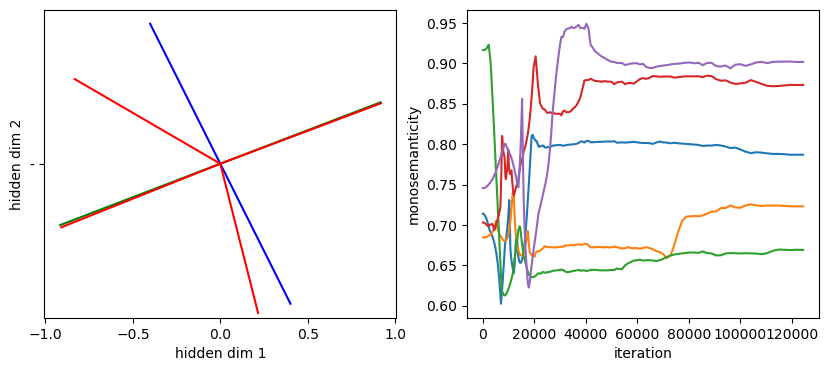

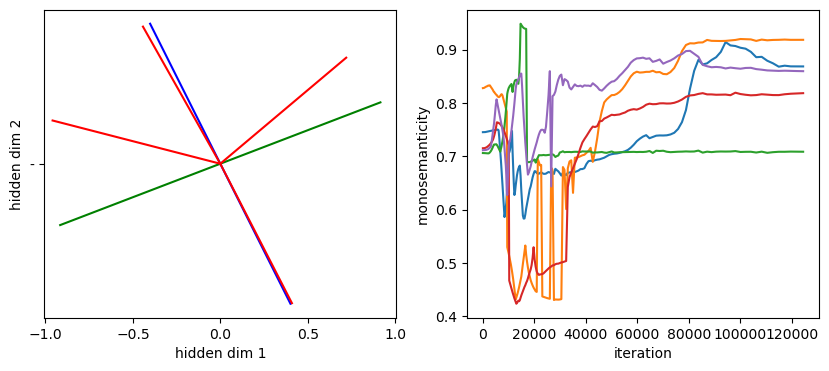

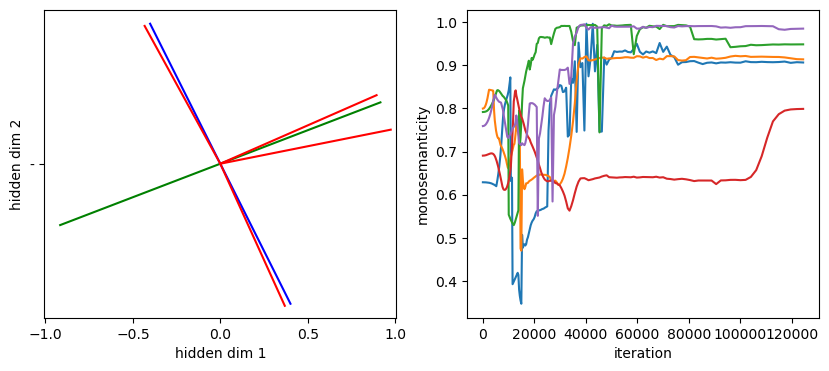

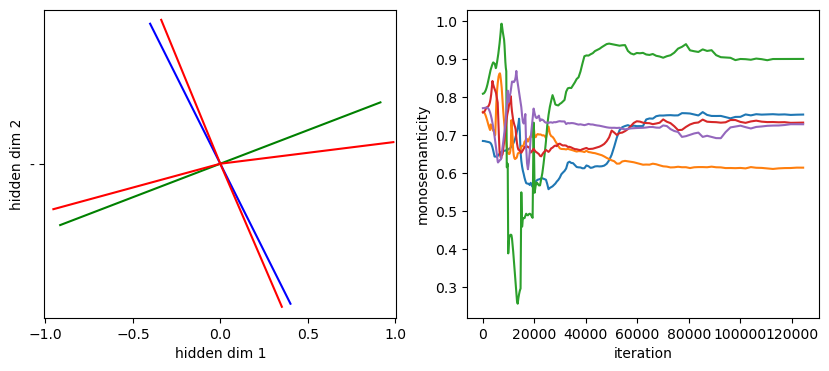

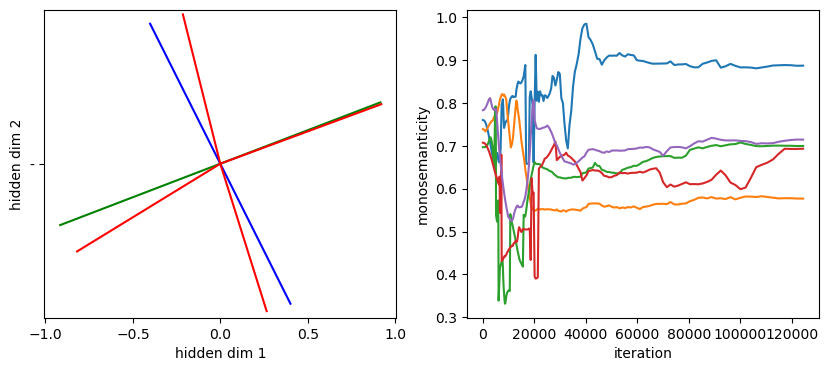

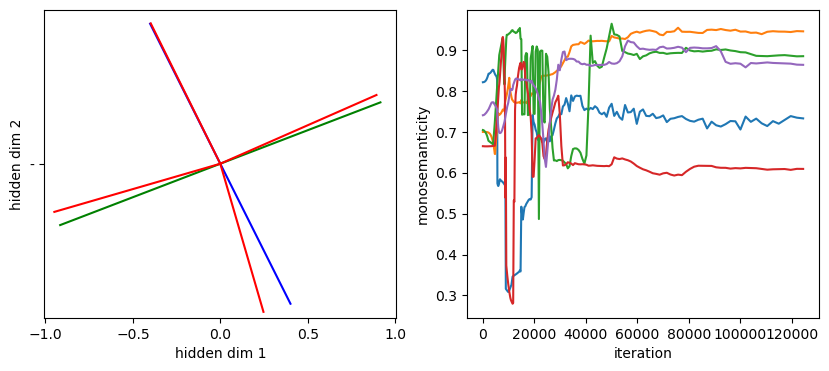

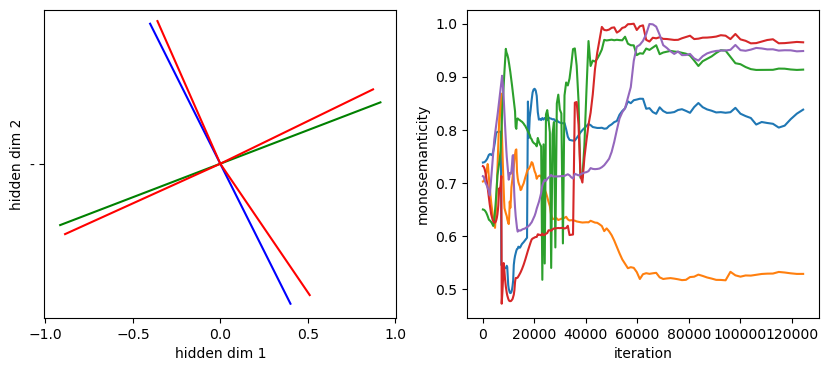

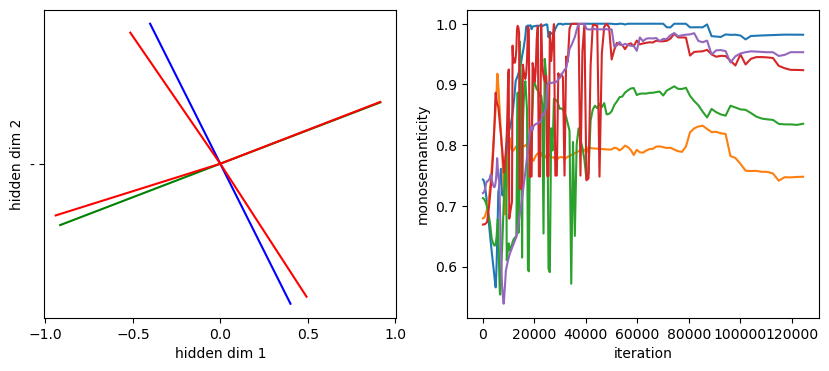

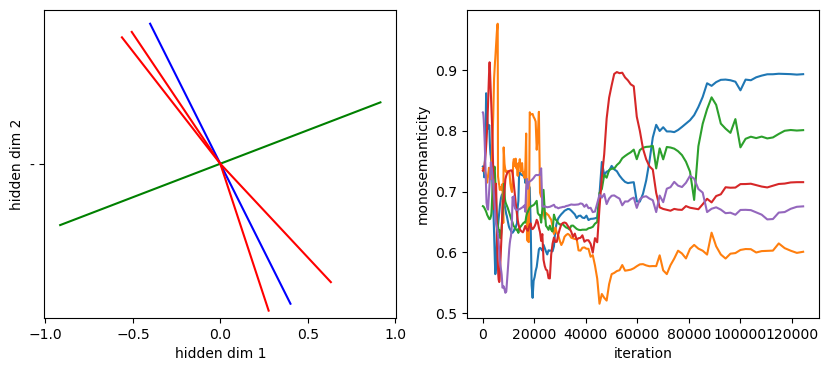

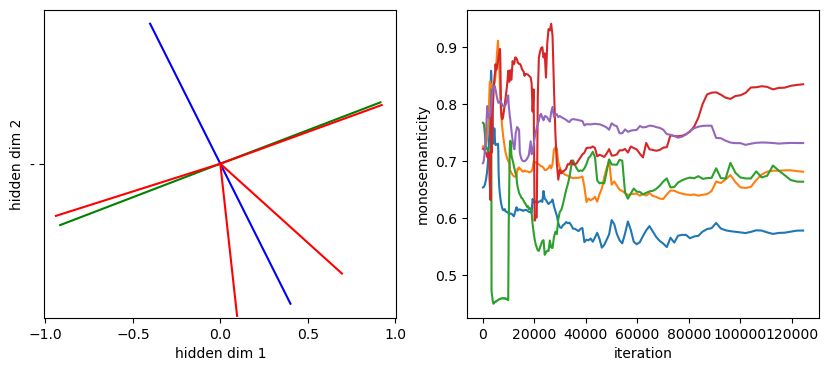

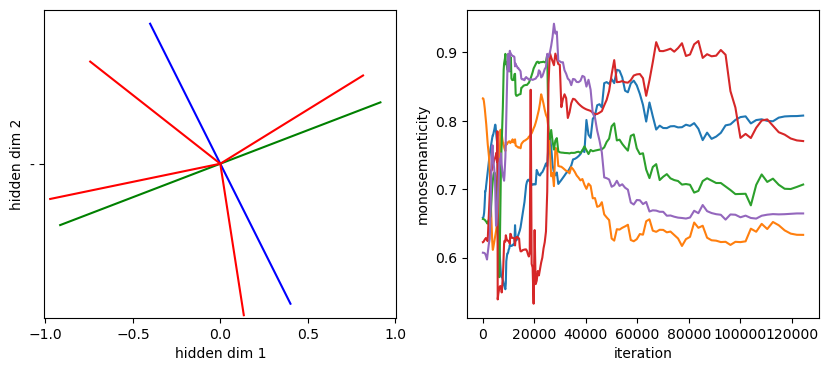

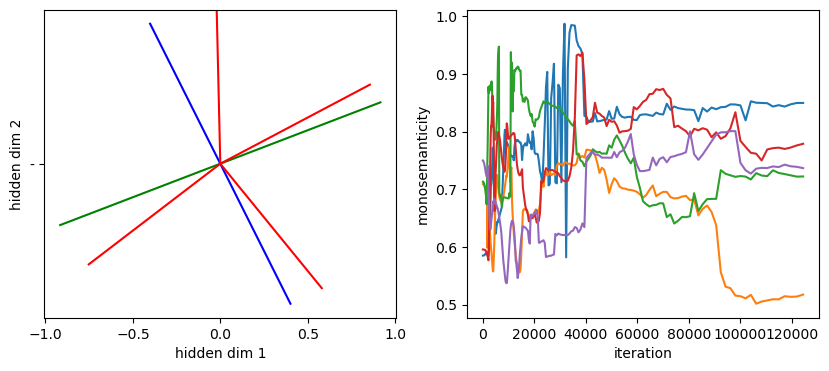

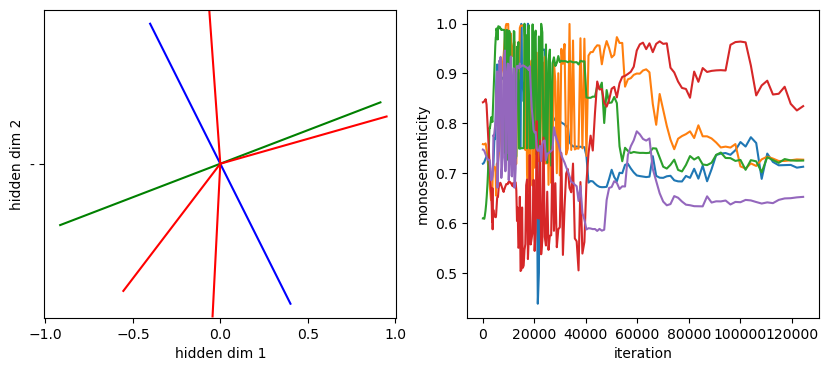

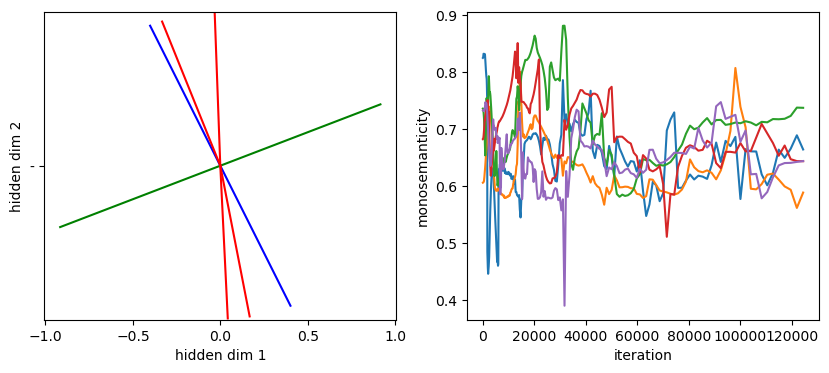

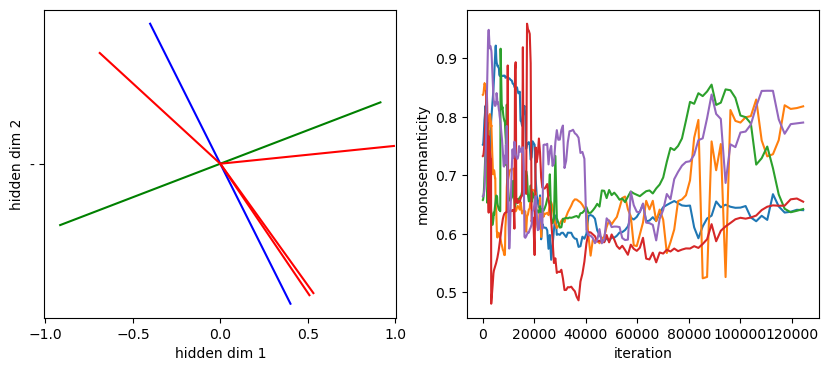

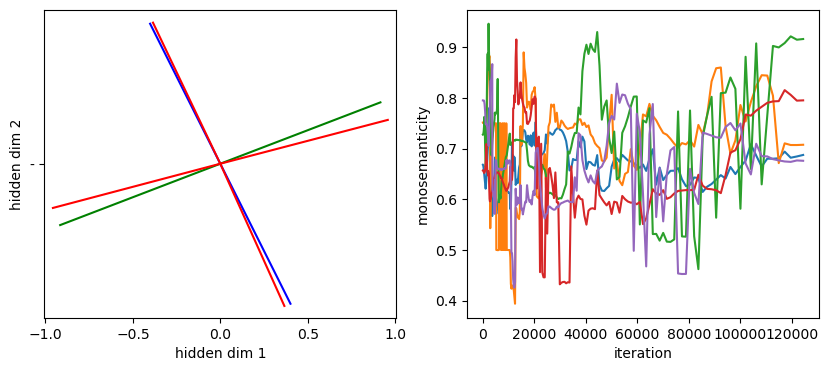

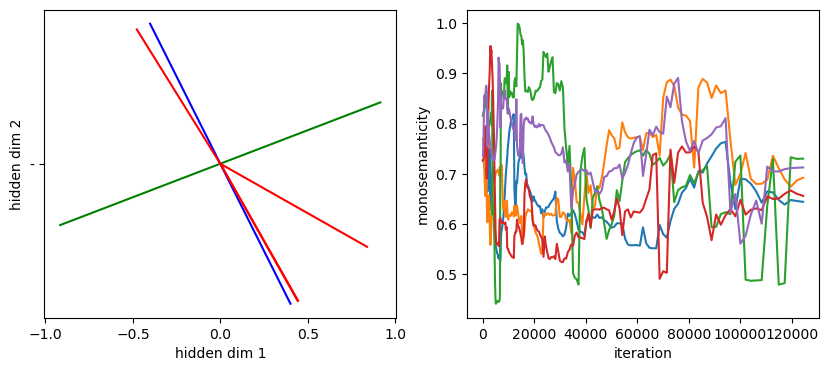

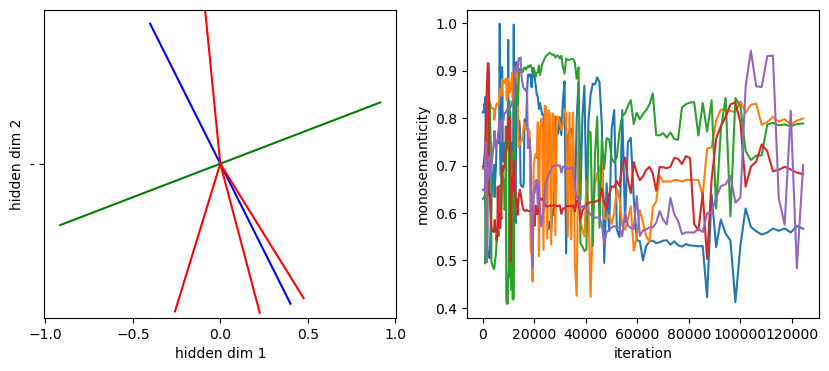

In [24]:
outdir = rootdir/'sae_OneHot75_uncorrelated'
outdir.mkdir(exist_ok=True)
d_sae = 4

saes = []
sae_logs = []
#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
for lr in [3e-5, 1e-4,3e-4, 1e-3, 3e-3]:
    for l1_coeff in [1e-2, 3e-2, 1e-1, 3e-1, 1e0]:
        en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                                n_inst=5,
                                training_samples = 128_000_000,
                                dict_mult=d_sae/cfg.hidden_size,
                                lr=lr,
                                adam_beta1=0,
                                wandb_project=proj_name,
                                l1_coeff=l1_coeff,
                                pre_encoder_bias=False
                                )
        print('running {}'.format(en_cfg.run_name))
        encoder = AutoEncoder(en_cfg).to(device)
        try:
            sae_log = encoder.load(outdir, run_name=en_cfg.run_name)
        except:
            sae_log = encoder.train(model,rootdir=outdir)
        saes.append((encoder, model))
        sae_logs.append(sae_log)
clear_output()

### SAE grid analysis

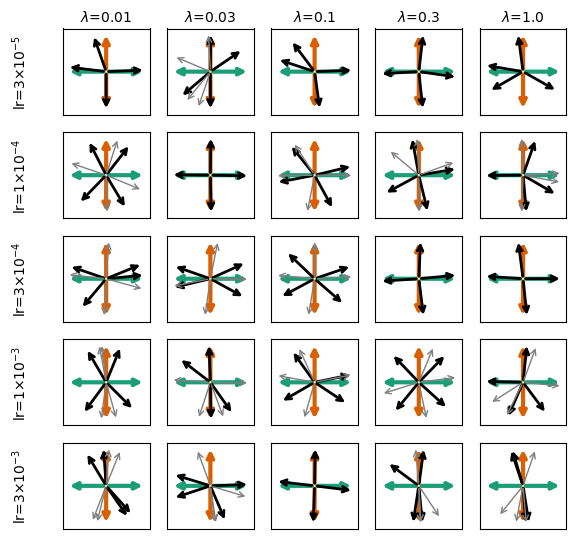

In [25]:
plot_grid(model, saes, filename='OneHot75_2d_grid.png')

/var/folders/ry/qny1f95136l2lpppg_d78n6c0000gq/T/ipykernel_22890/3109989520.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(6.5,2))


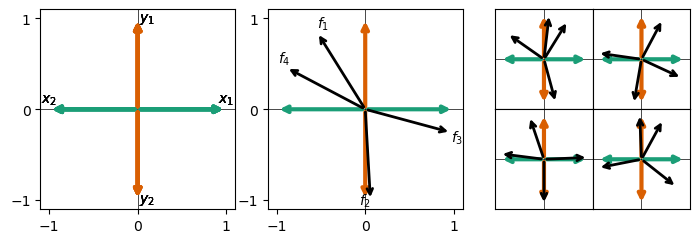

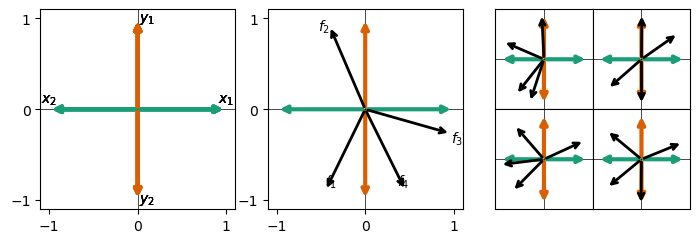

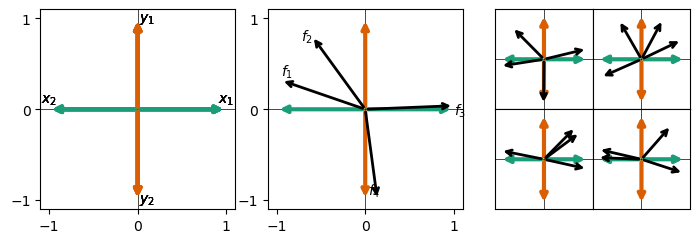

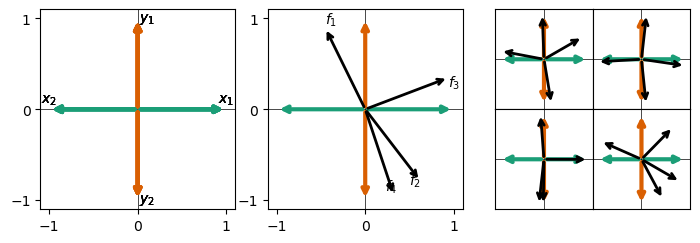

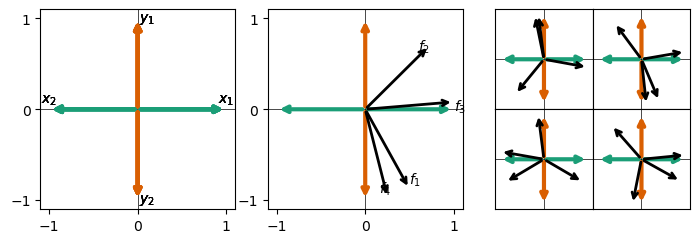

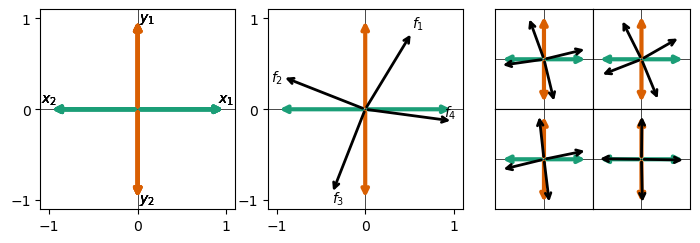

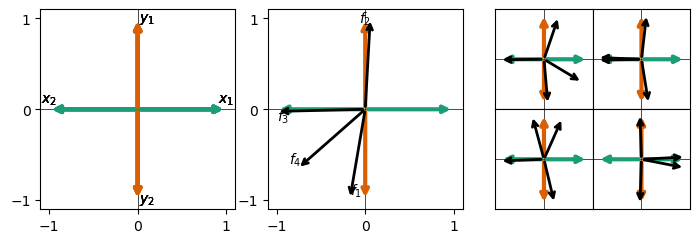

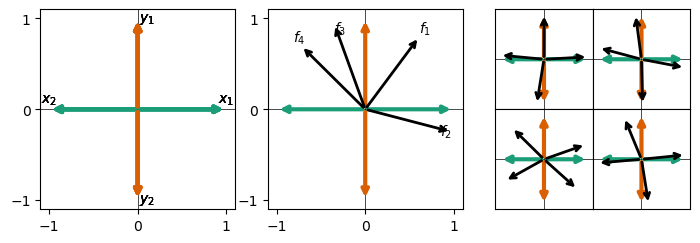

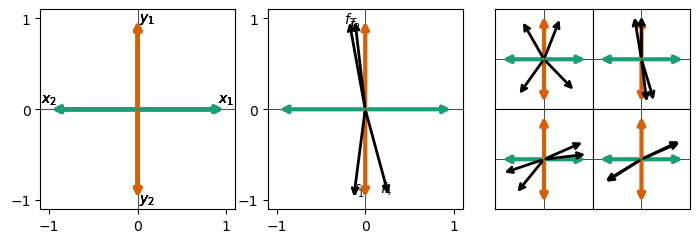

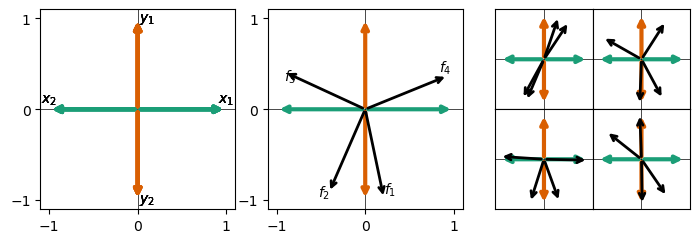

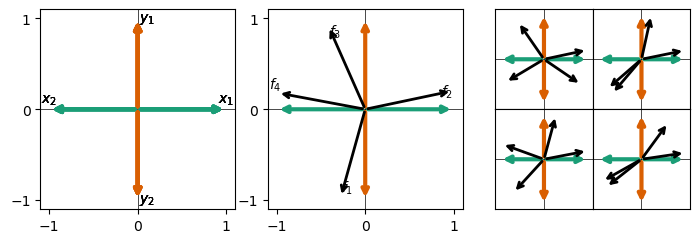

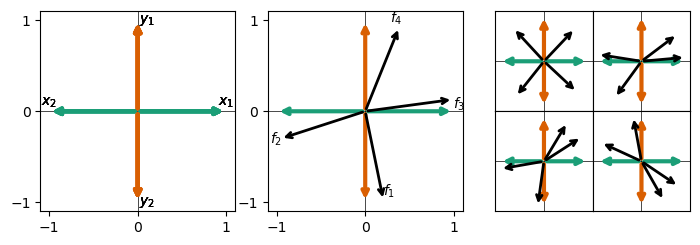

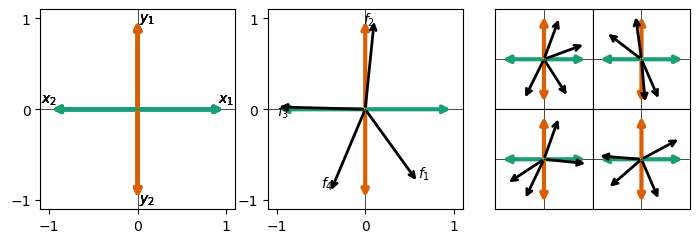

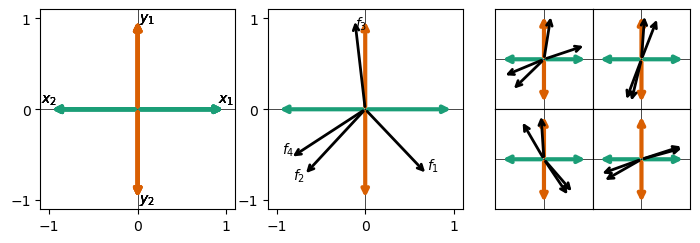

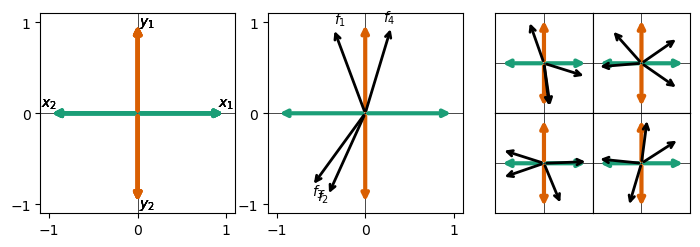

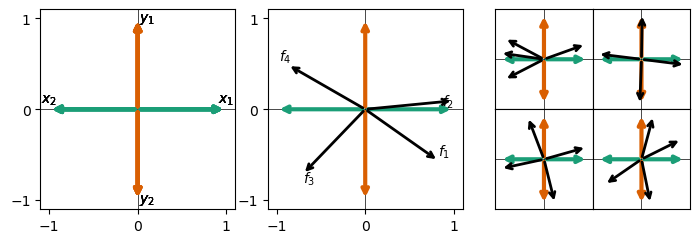

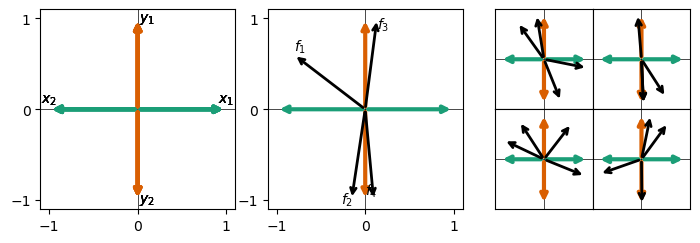

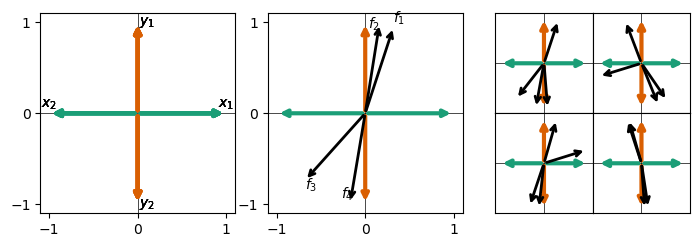

In [26]:
for i in range(len(saes)):
    plot_schematic(model, saes[i][0])

# Uncorrelated features with cos-sim penalty

### Model and first SAE

In [5]:
outdir=rootdir/'toy_models'
outdir.mkdir(exist_ok=True)
cfg = ToyModelConfig(hidden_size=2,
                     feat_sets=(2,2),
                     batches=10000, 
                     batch_size=1000,
                     correlated_feature_indices=(1,1),
                     correlated_feature_boost=0,
                     set_magnitude_correlation=0,
                     active_features_per_draw=1, # seems important for getting composed pairs.
                     )

model = ComposedFeatureTMS(cfg).to(device)
try:
    print('attempting to load')
    model.load(outdir, run_name=cfg.run_name)
except:
    print('training')
    model.train(outdir=outdir)

probability table: 
tensor([[0.2500, 0.2500],
        [0.2500, 0.2500]])
attempting to load


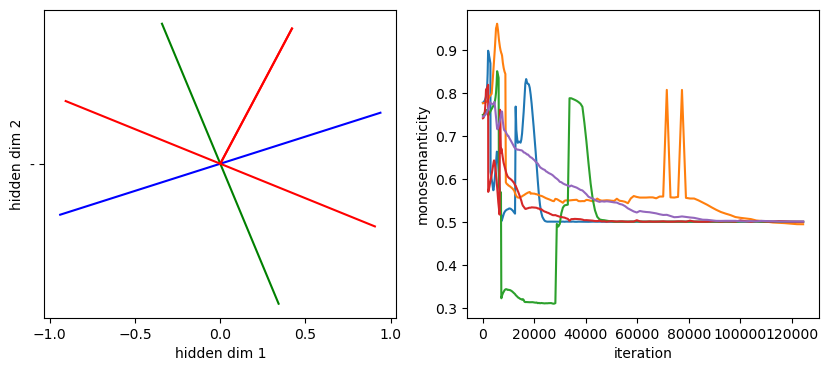

In [12]:
lr=3e-4
l1_coeff = 0.3
outdir = rootdir/'sae_cossim_penalty'
outdir.mkdir(exist_ok=True)


#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                        n_inst=5,
                        training_samples = 128_000_000,
                        dict_mult=cfg.input_size/cfg.hidden_size,
                        lr=lr,
                        adam_beta1=0,
                        wandb_project=proj_name,
                        l1_coeff=l1_coeff,
                        pre_encoder_bias=False,
                        include_cossim_penalty=True,
                        cossim_coeff=0.1
                        )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
sae_log = encoder.train(model,rootdir=outdir)
saes.append((encoder, model))
single_sae = encoder

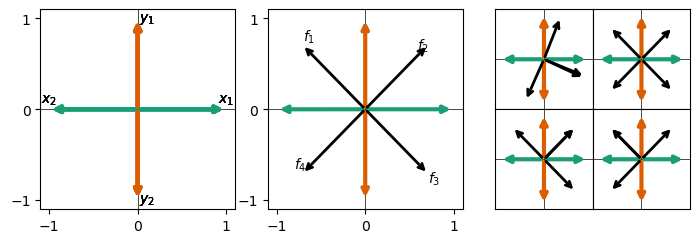

In [13]:
plot_schematic(model, encoder)

# Simple Uncorrelated Model (2 hidden dims)



## Model


In [ ]:

Sparsity = 0.99
cfg = ToyModelConfig(
                    input_size=5, 
                    hidden_size=2, 
                    batches=5000, 
                    batch_size=1000,
                    sparsity = lambda N: Sparsity
                    )

model = UncorrelatedTMS(cfg).to(device)
model.train()



## SAE


In [ ]:

#This worked pretty well but not perfectly for l1_coeff = 0.25. normalize_in_l2 is faulty here because lots of activations are 0.
lr=1e-3
l1_coeff = 0.25

saes = []
#can add a loop here and append
proj_name = f"autoencoder-uncorrelated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                           n_inst=5,
                           training_samples = 32_000_000,
                            dict_mult=cfg.input_size/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False,
                           normalize_in_l2=False
                           )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
encoder.train(model,rootdir=rootdir)# plotter=plotter)
saes.append(encoder)



# Simple Correlated model (2 hidden dims)



## Model


In [ ]:

Sval = 0.99
cfg = ToyModelConfig(
                    feat_sets=[2]*3,
                    hidden_size=2,
                    batches=5000,
                    batch_size=1000,
                    sparsity = lambda N: Sval
                    )

model = CorrelatedTMS(cfg).to(device)
model.train()



## SAE


In [ ]:
lr=3e-3
l1_coeff = 0.25

saes = []
#can add a loop here and append
proj_name = f"autoencoder-correlated"
en_cfg = AutoEncoderConfig(d_in=cfg.hidden_size,
                           n_inst=5,
                           training_samples = 32_000_000,
                            dict_mult=cfg.input_size/cfg.hidden_size,
                            lr=lr,
                            adam_beta1=0,
                            wandb_project=proj_name,
                            l1_coeff=l1_coeff,
                            pre_encoder_bias=False,
                           normalize_in_l2=False,
                           ghost_grads_cooldown=100,
                           )
print('running {}'.format(en_cfg.run_name))
encoder = AutoEncoder(en_cfg).to(device)
encoder.train(model,rootdir=rootdir)# plotter=plotter)
saes.append(encoder)